In [ ]:
# Import libraries
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda ,Compose
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
import torch.autograd as autograd
import seaborn as sns

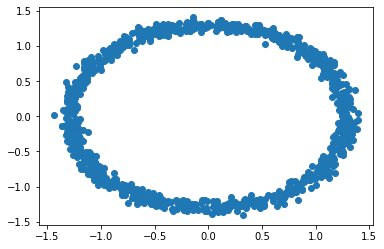

In [ ]:
def get_circle_dataset(n = 1000):
    dr,angle = np.random.randn(n)*0.05,2*np.pi*np.random.rand(n)
    r = dr+1.3
    x = r*np.sin(angle)
    y = r*np.cos(angle)
    data = np.concatenate([x[np.newaxis,:],y[np.newaxis,:]]).T
    return data

circle_data = get_circle_dataset()
plt.scatter(circle_data[:,0],circle_data[:,1])

In [ ]:
#critic
C = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
   )

latent_size = 16

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, 32),
     nn.Tanh(),
    nn.Linear(32, 32),
     nn.Tanh(),
    nn.Linear(32, 32),
     nn.Tanh(),
    nn.Linear(32, 2),
   
    )

In [ ]:
from torch.utils.data import DataLoader,TensorDataset

batch_size = 500
num_epochs = 2500
lr = 5e-5

real_data = torch.FloatTensor(circle_data)
data_set = TensorDataset(real_data)
data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)

c_optimizer = torch.optim.RMSprop(C.parameters(), lr=lr)
g_optimizer = torch.optim.RMSprop(G.parameters(), lr=lr)




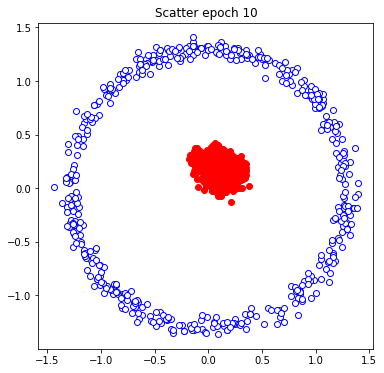

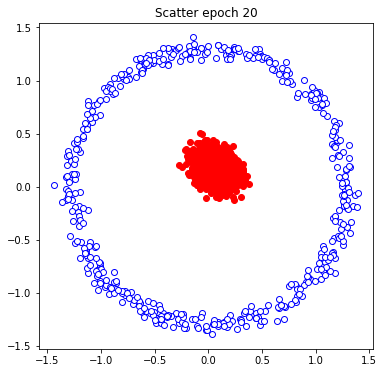

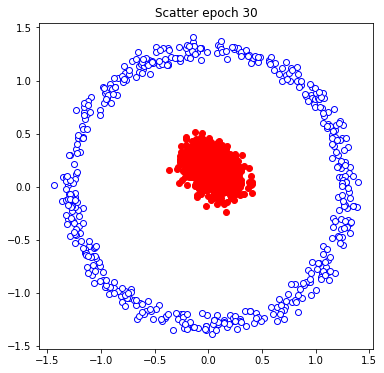

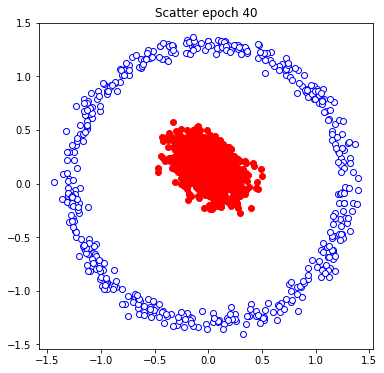

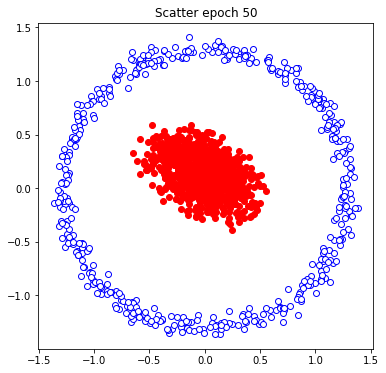

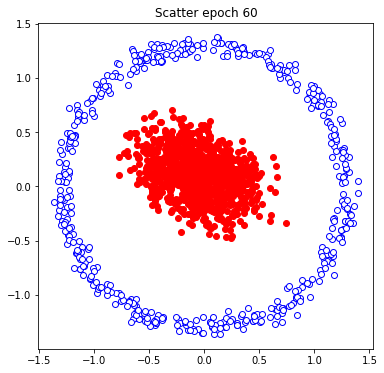

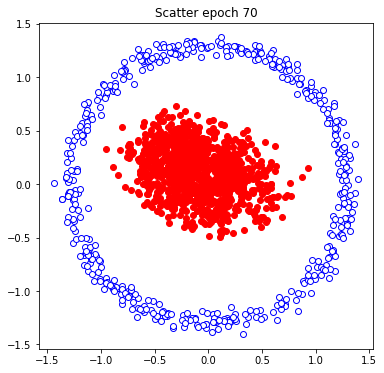

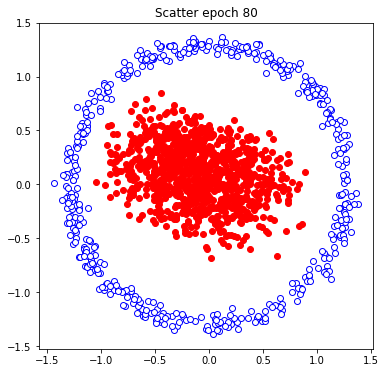

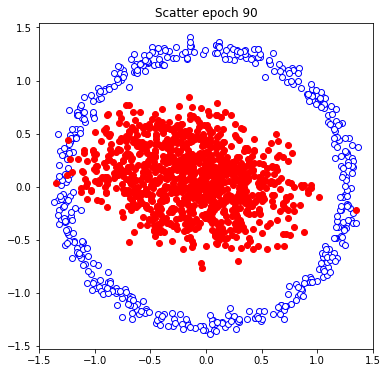

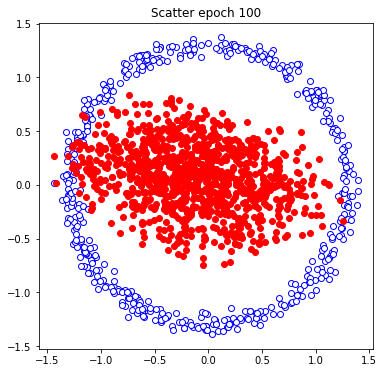

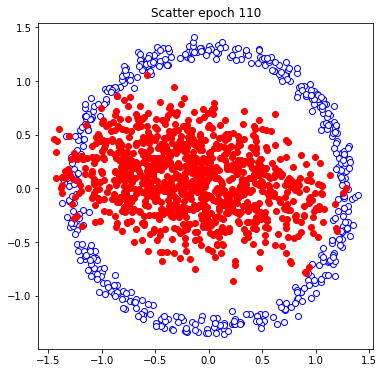

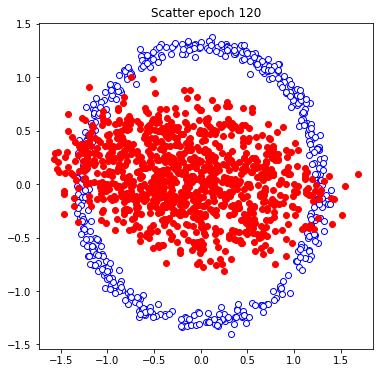

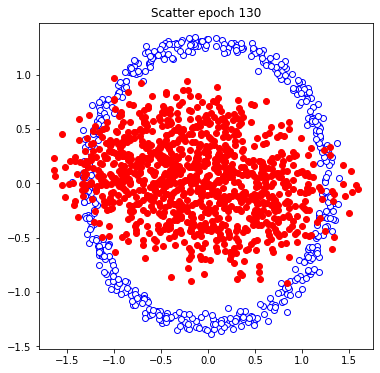

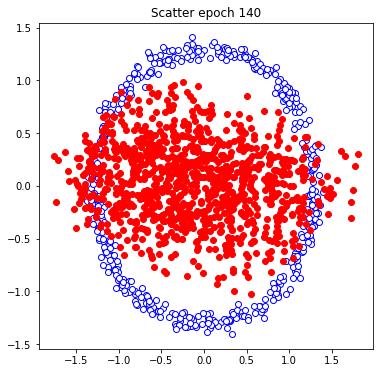

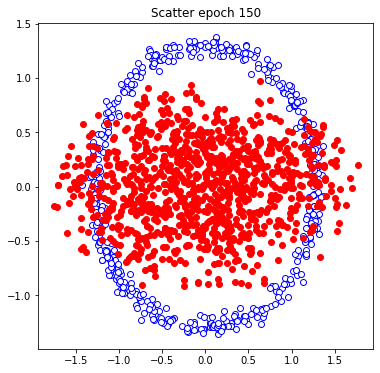

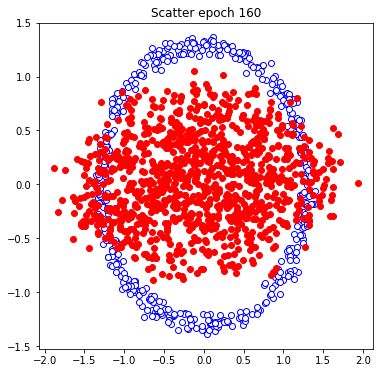

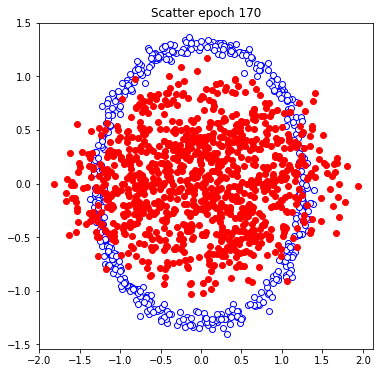

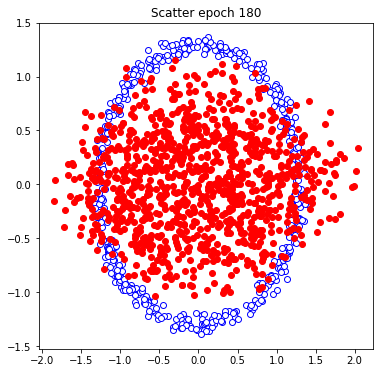

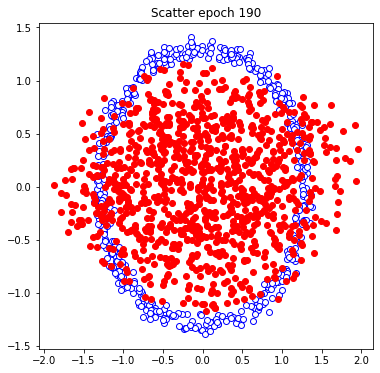

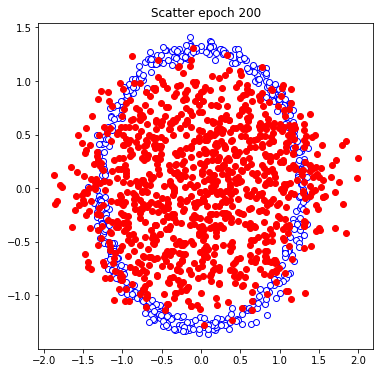

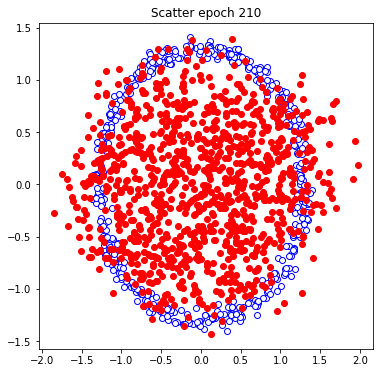

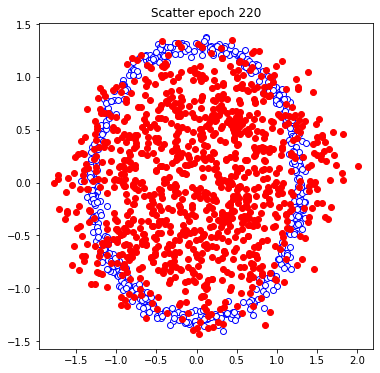

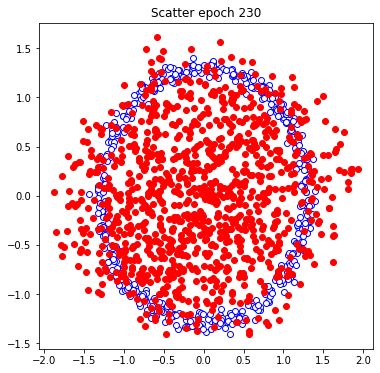

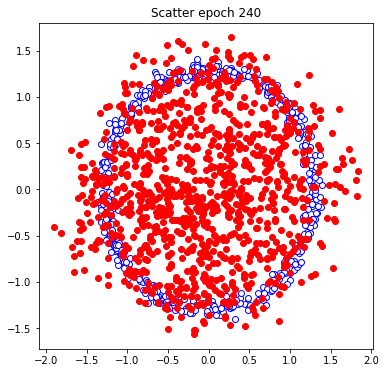

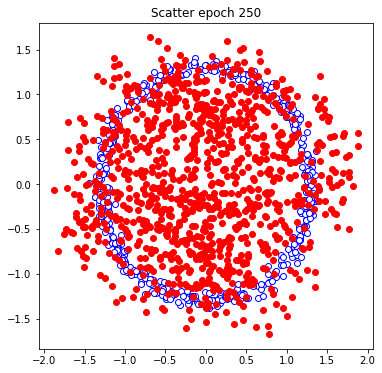

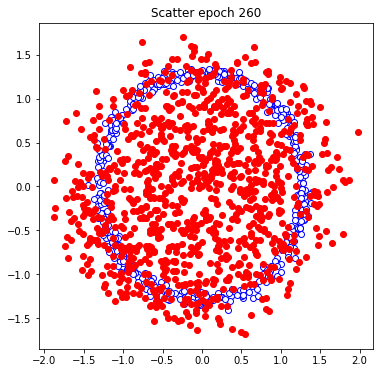

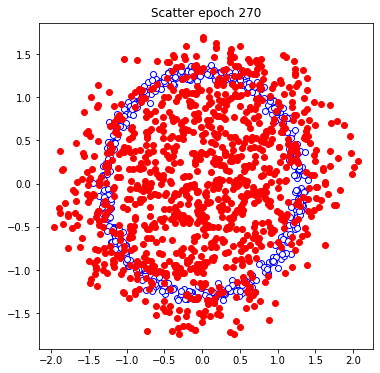

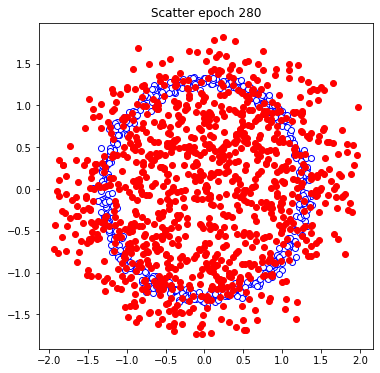

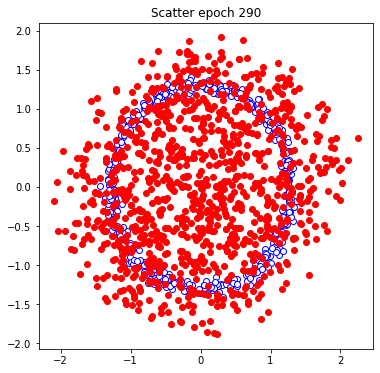

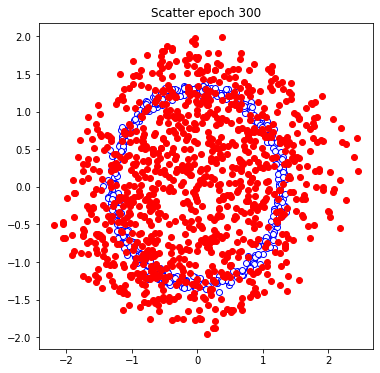

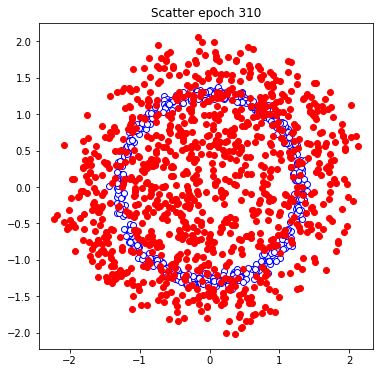

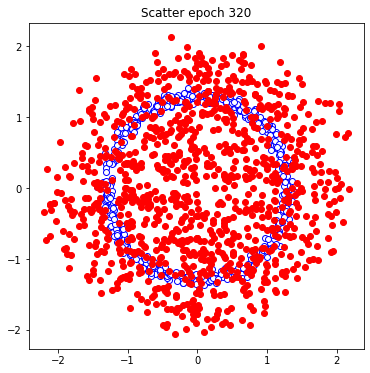

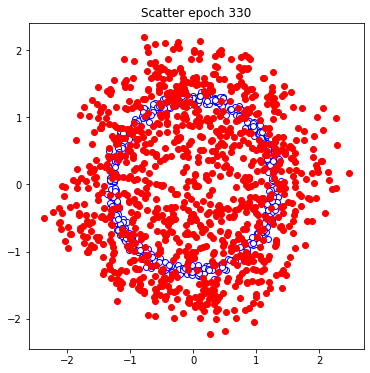

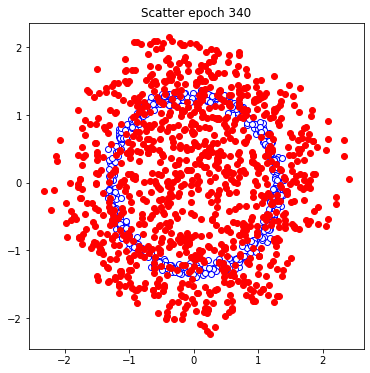

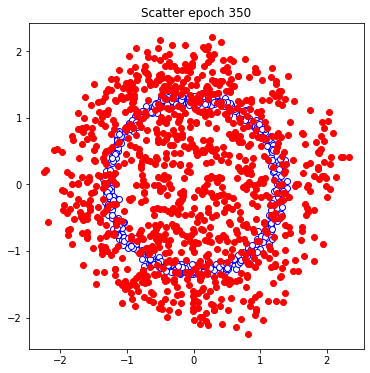

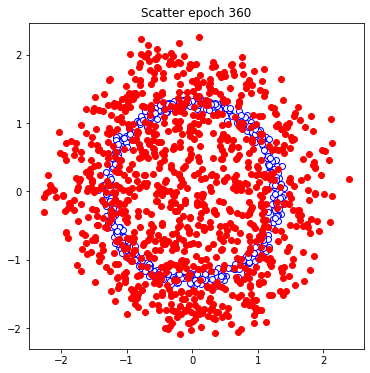

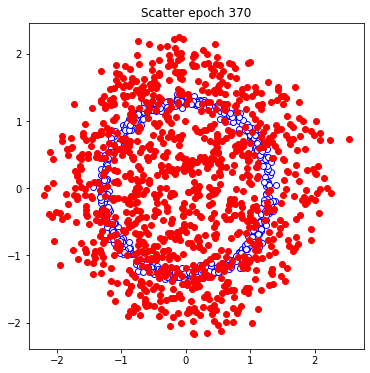

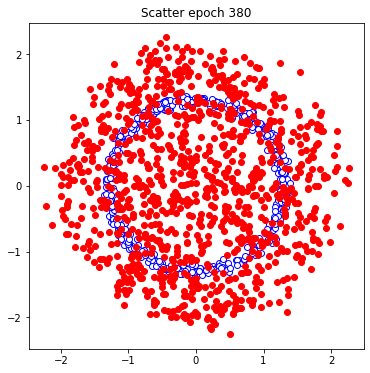

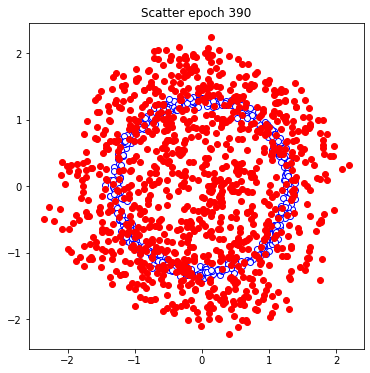

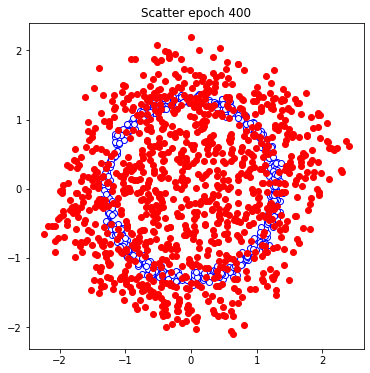

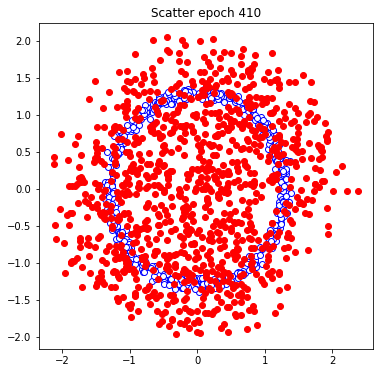

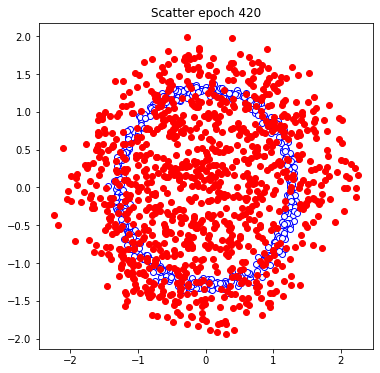

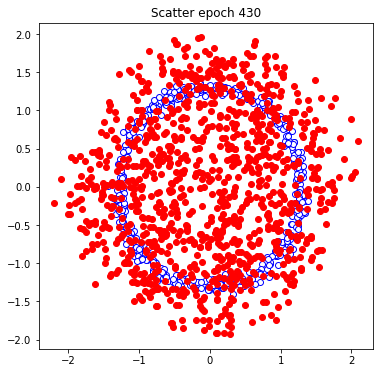

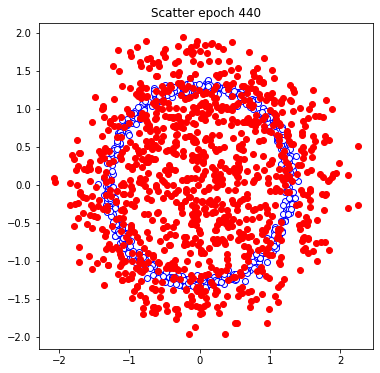

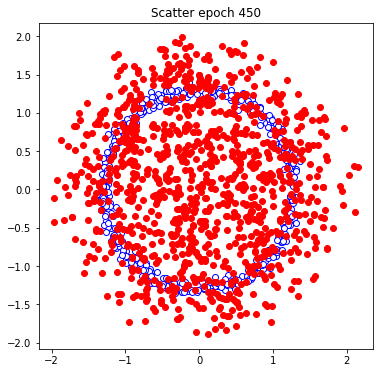

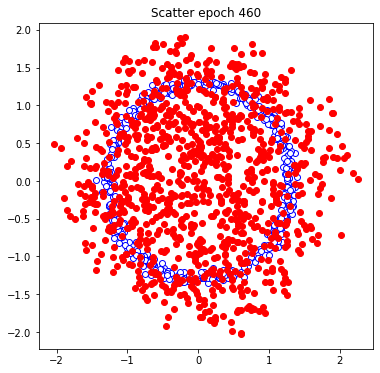

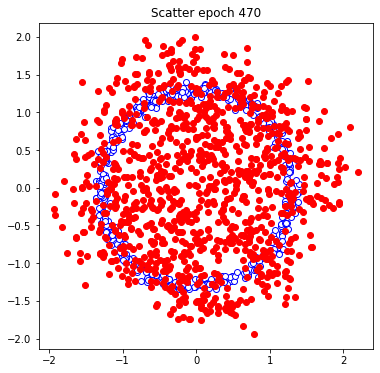

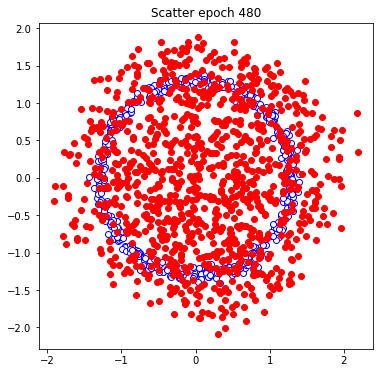

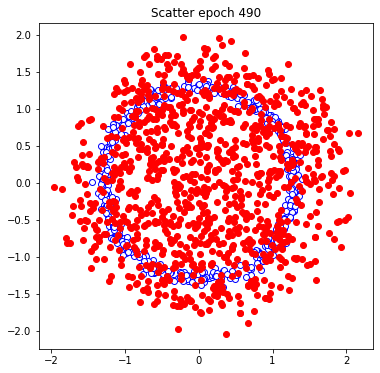

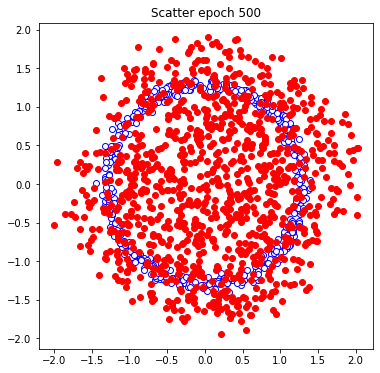

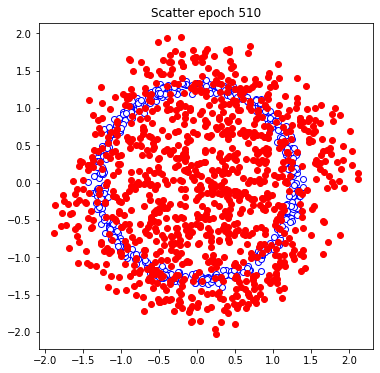

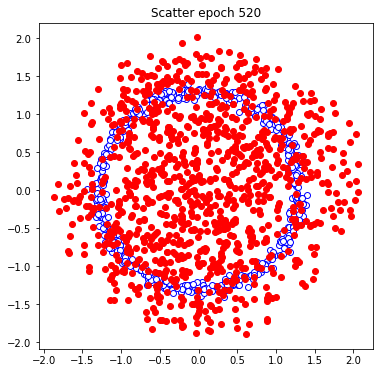

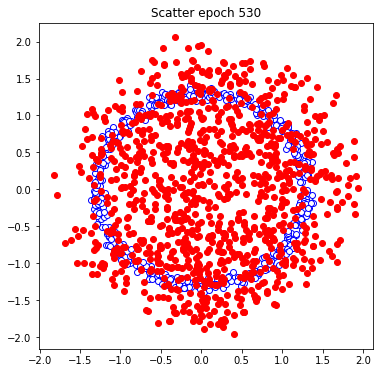

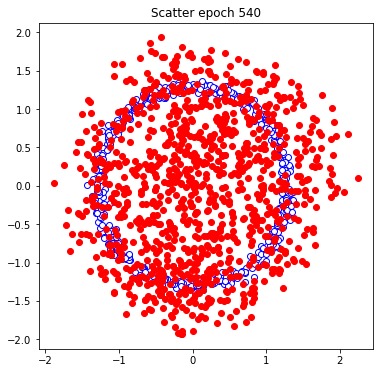

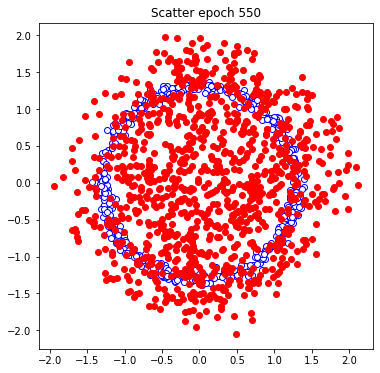

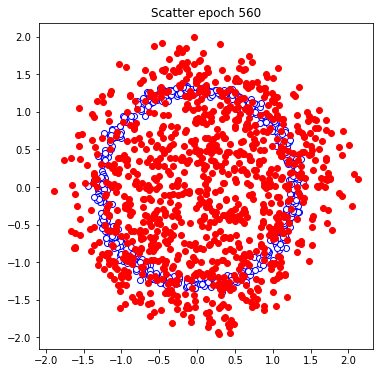

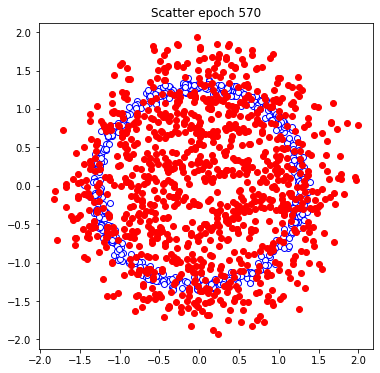

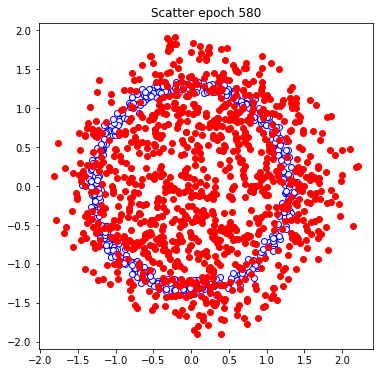

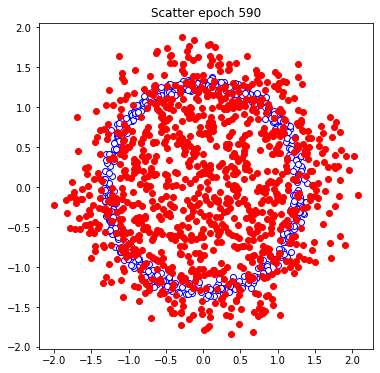

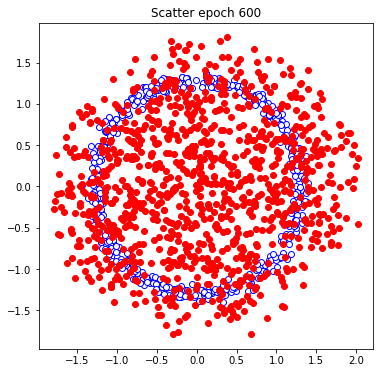

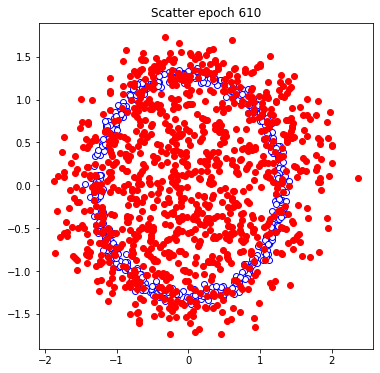

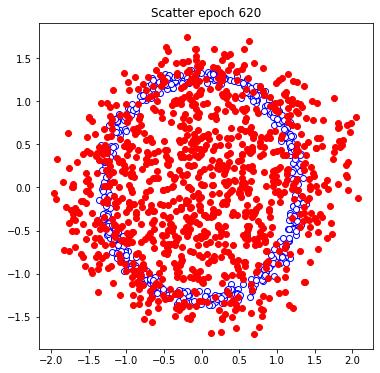

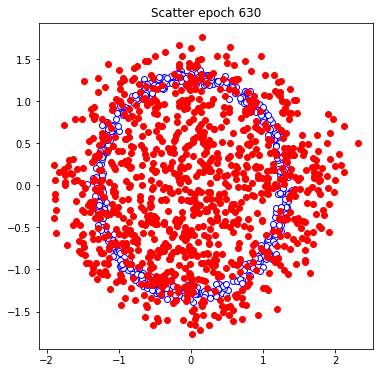

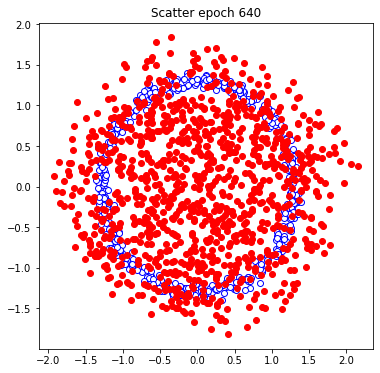

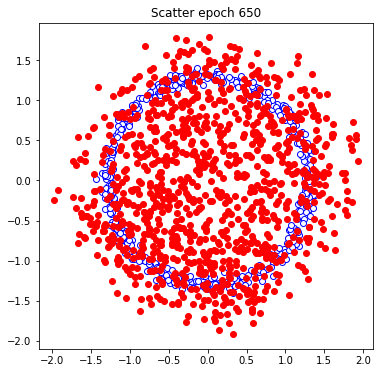

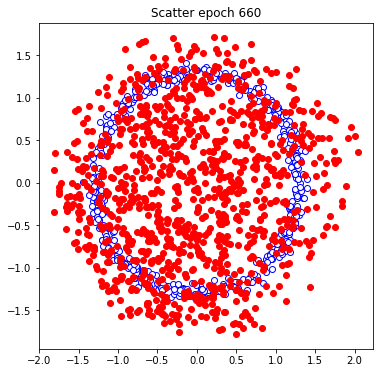

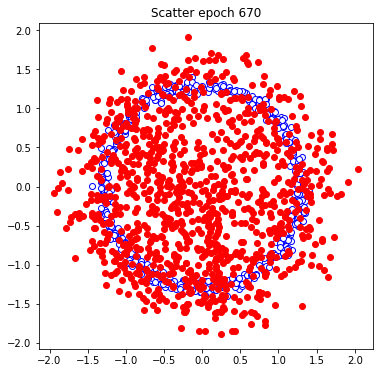

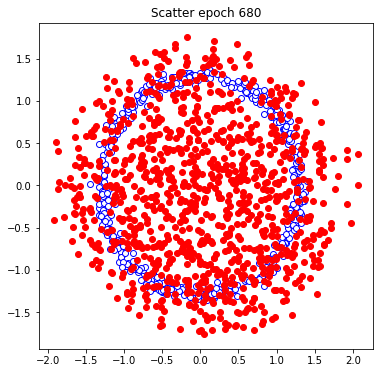

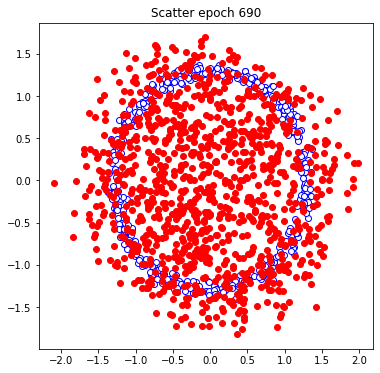

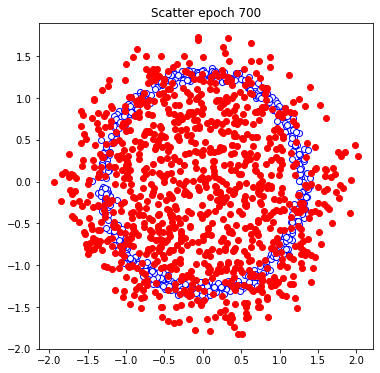

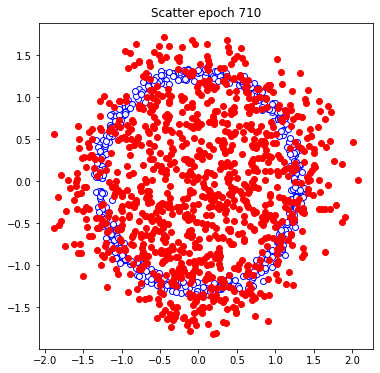

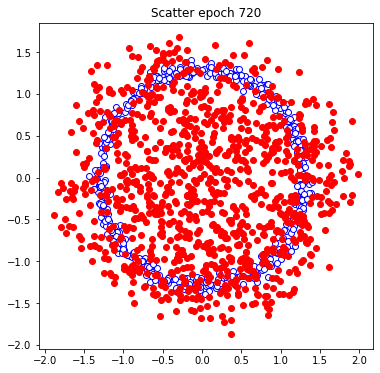

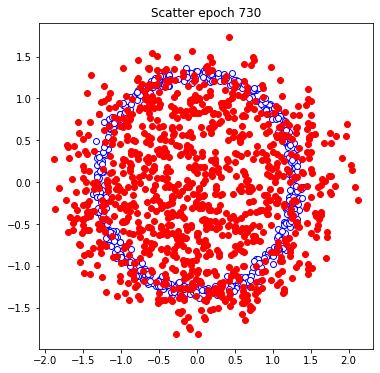

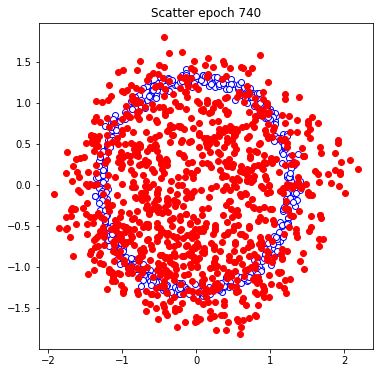

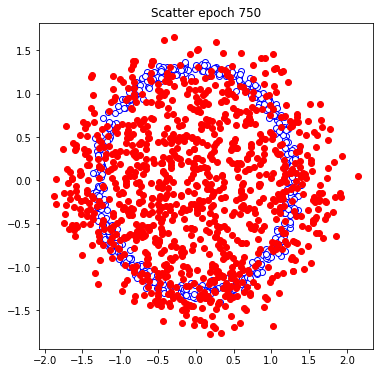

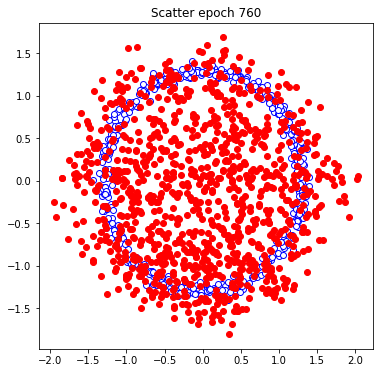

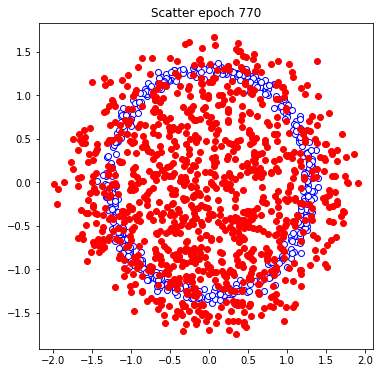

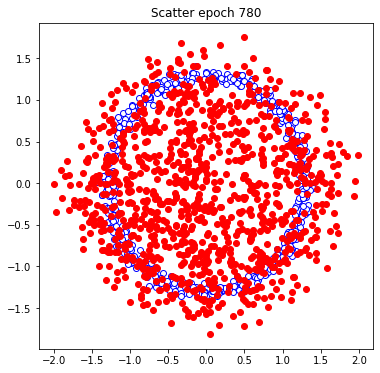

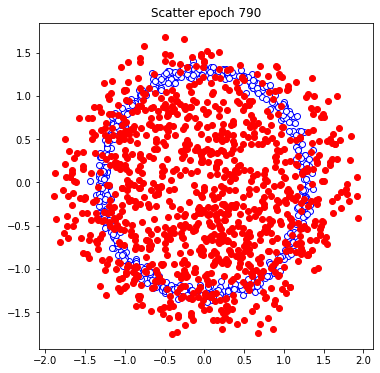

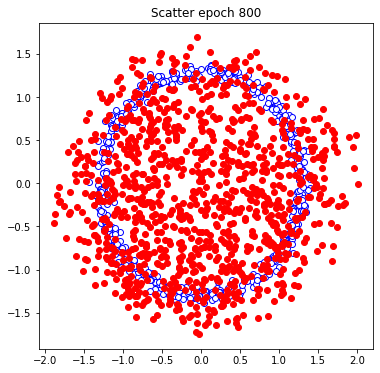

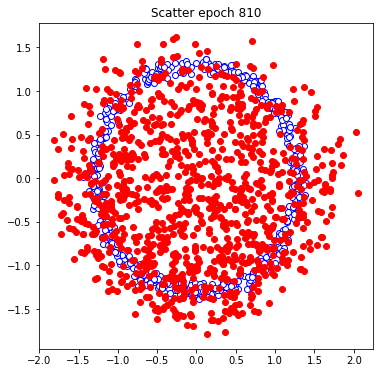

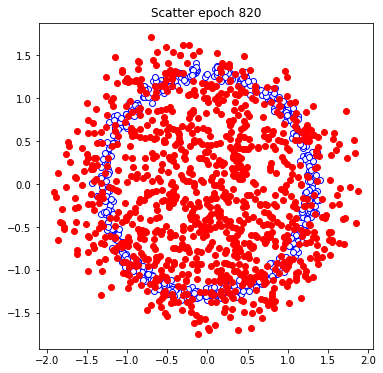

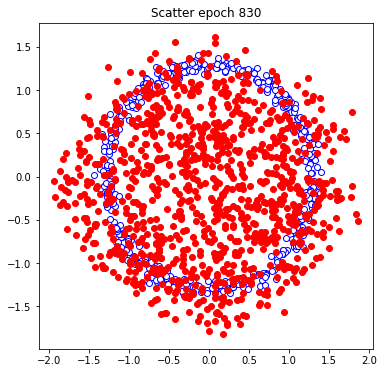

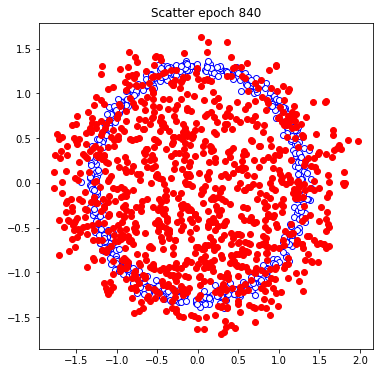

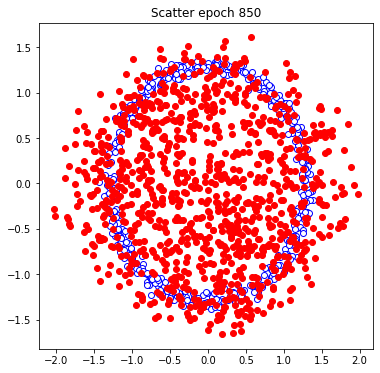

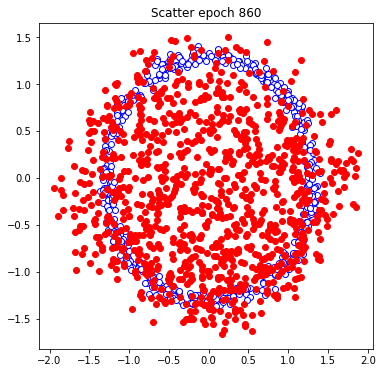

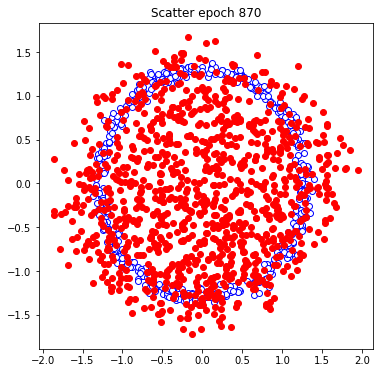

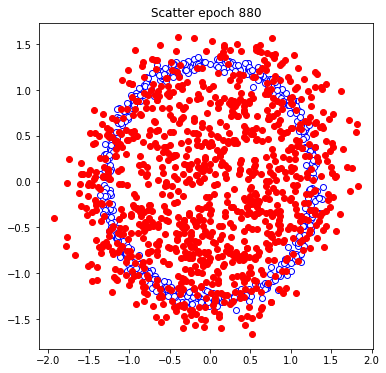

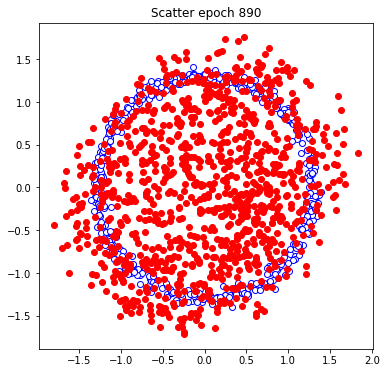

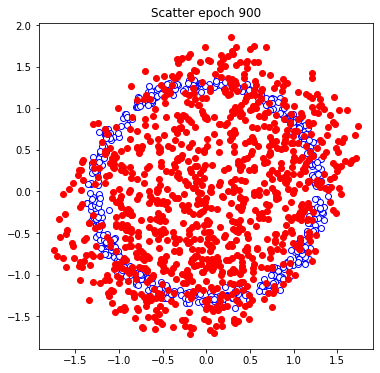

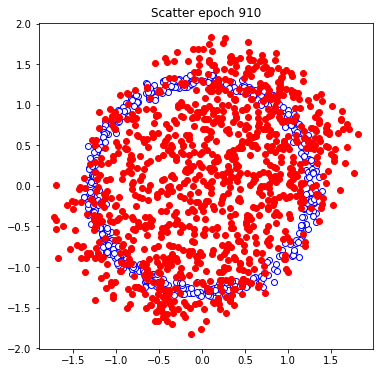

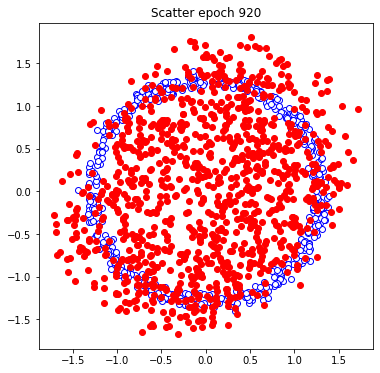

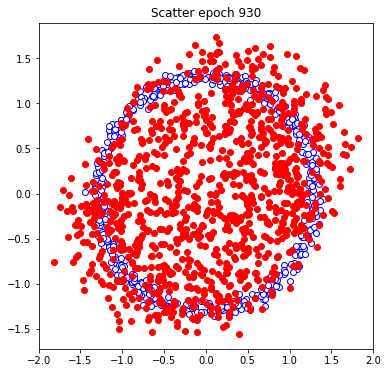

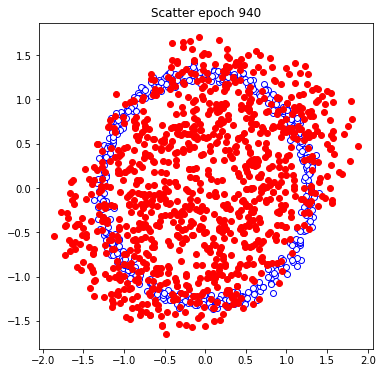

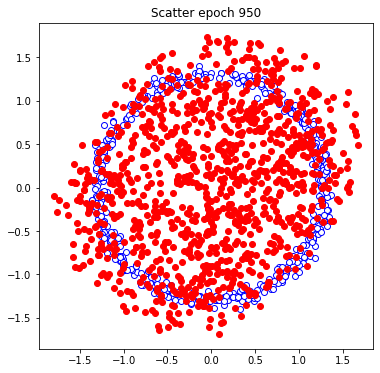

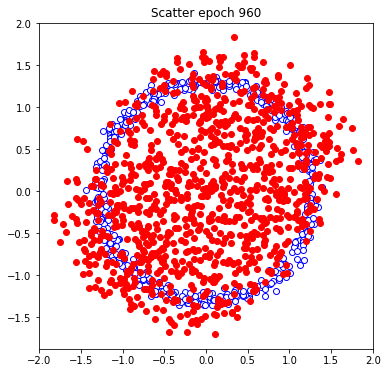

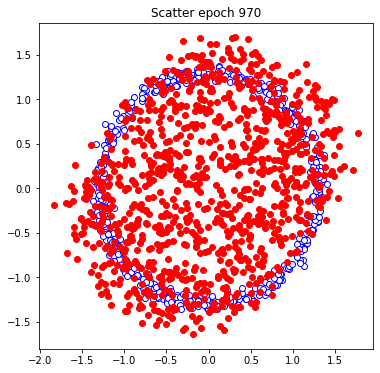

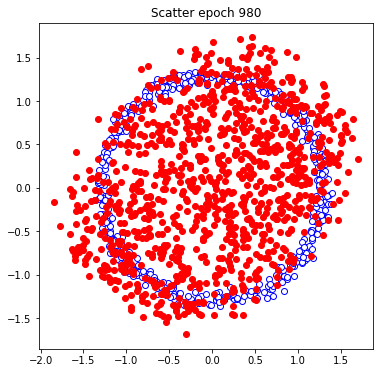

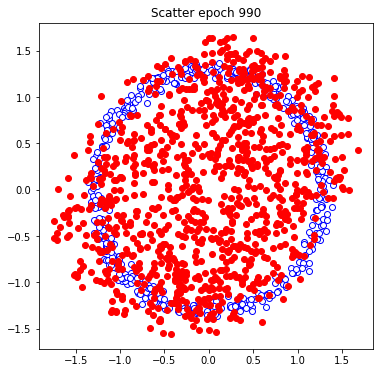

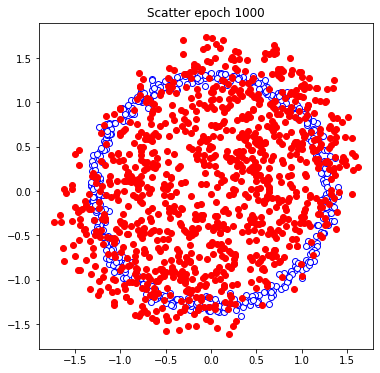

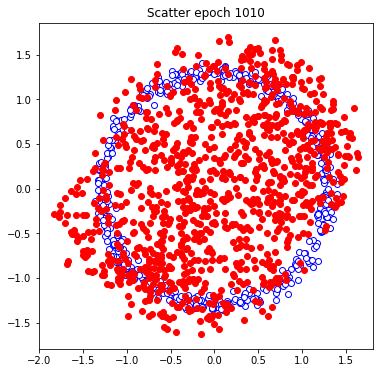

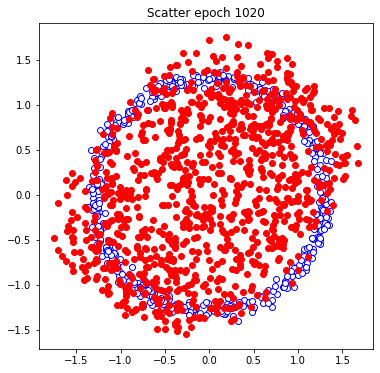

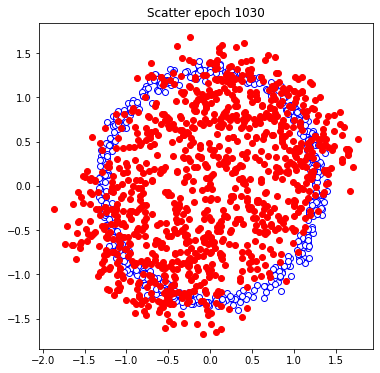

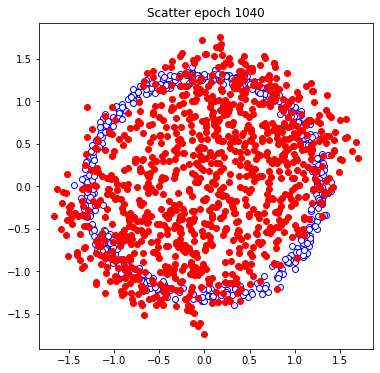

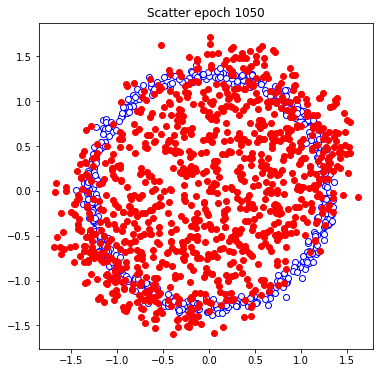

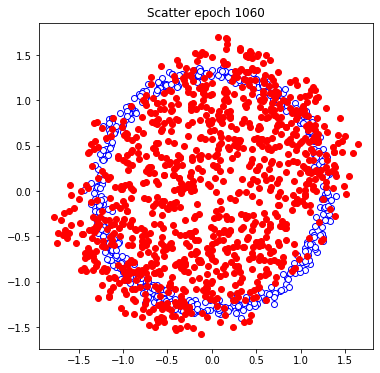

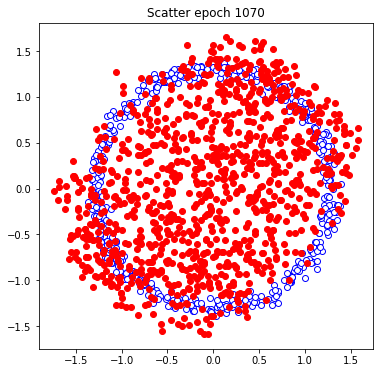

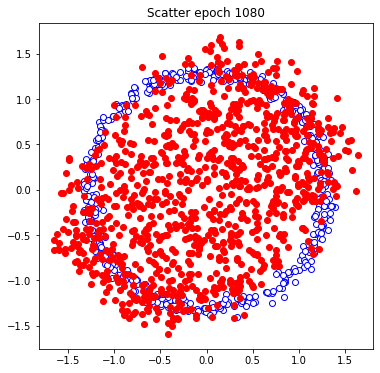

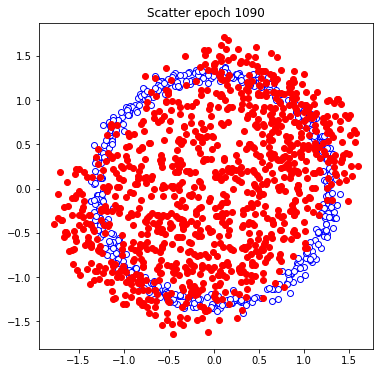

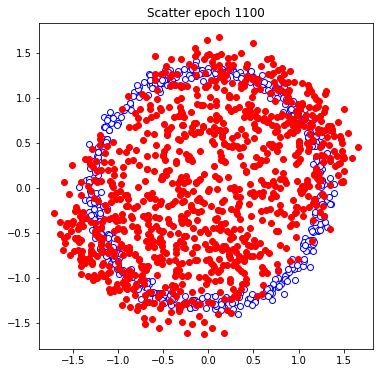

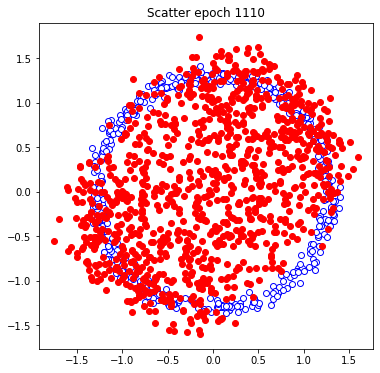

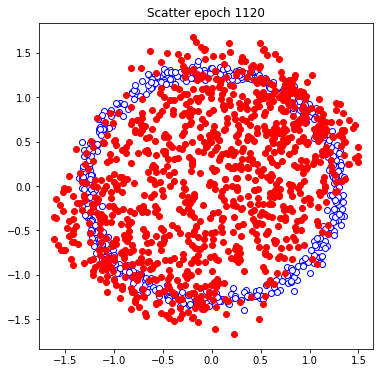

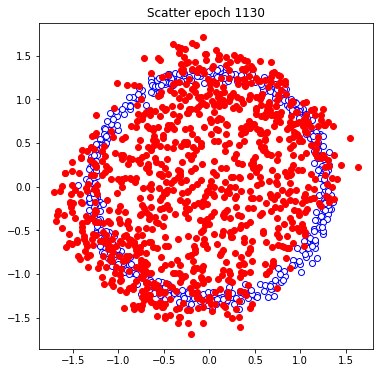

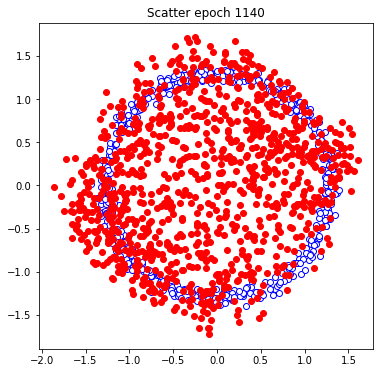

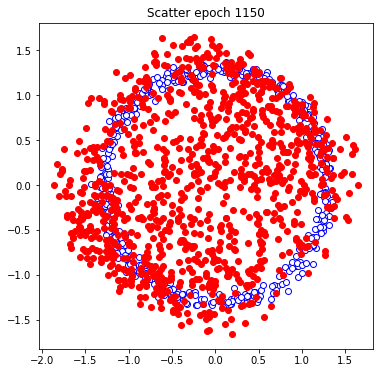

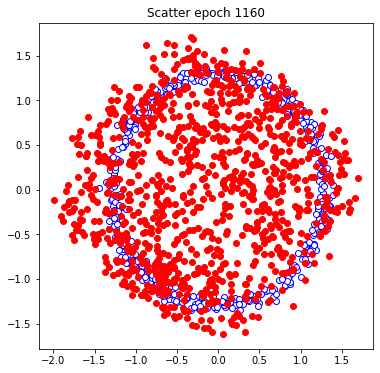

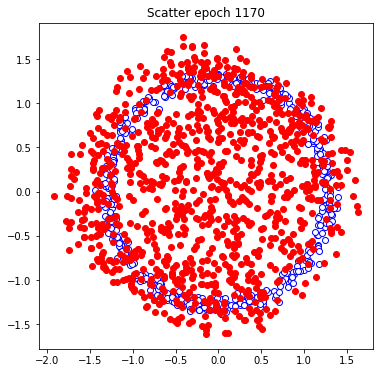

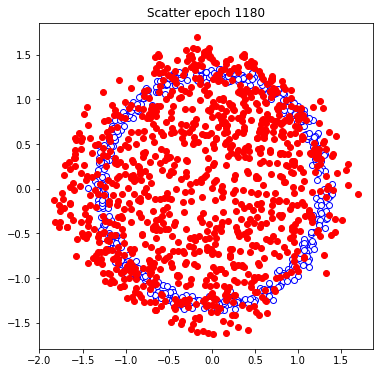

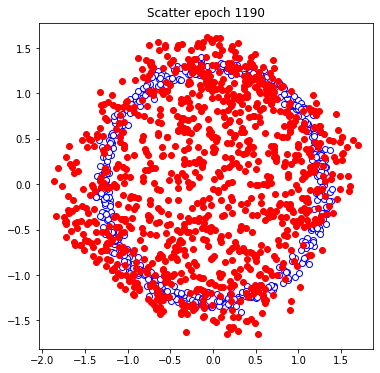

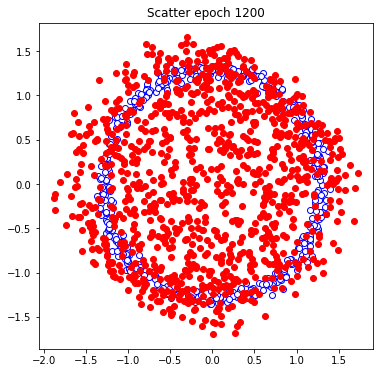

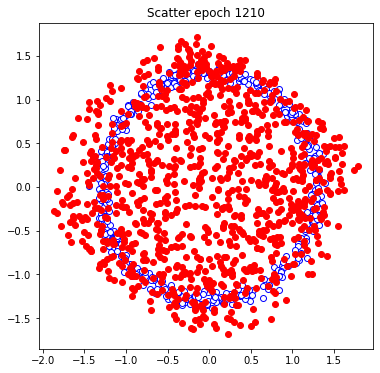

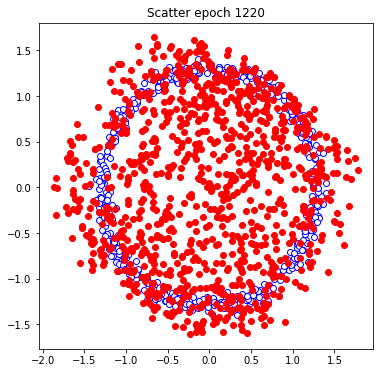

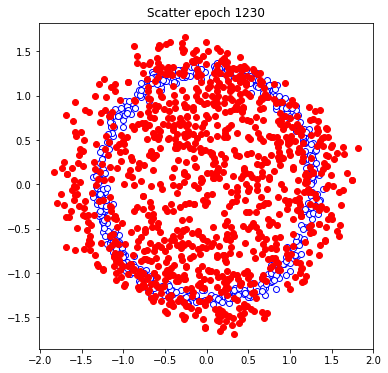

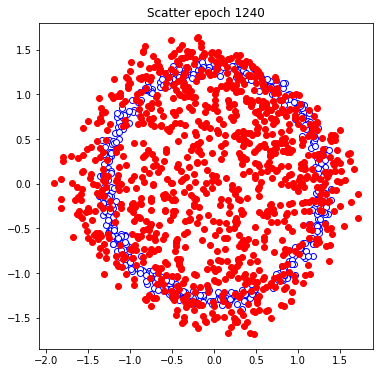

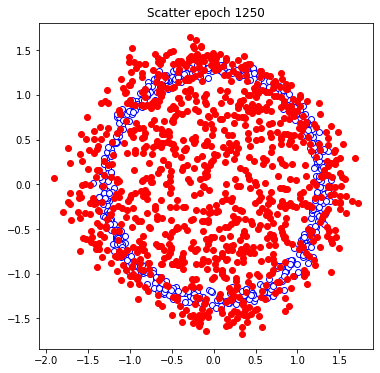

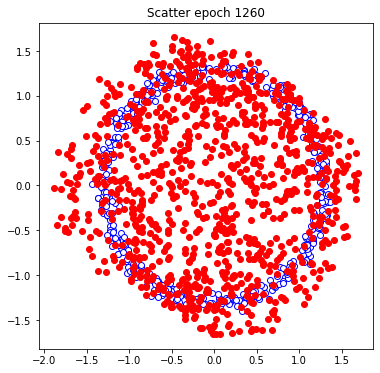

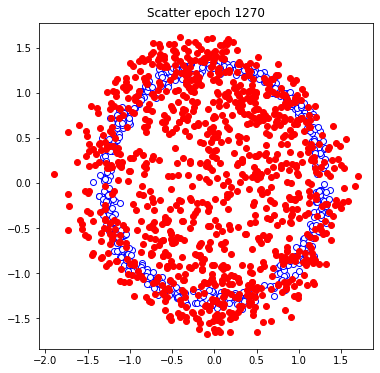

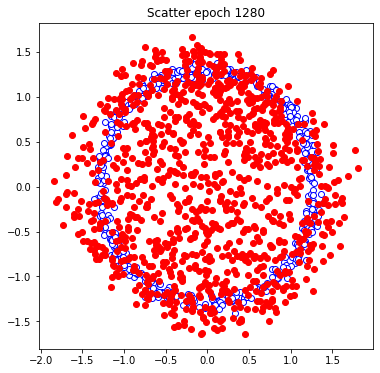

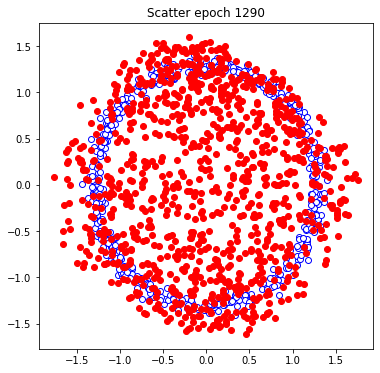

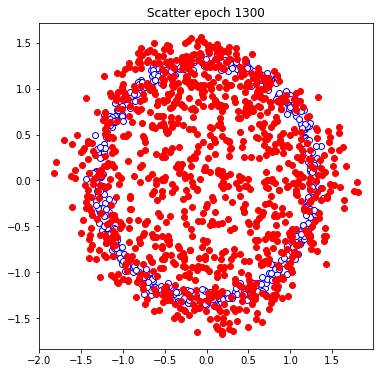

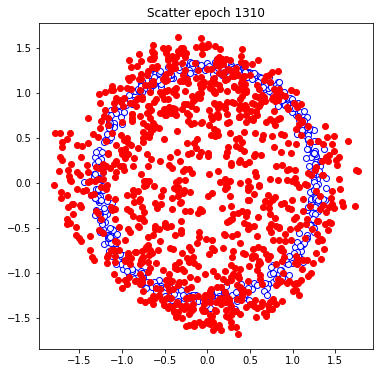

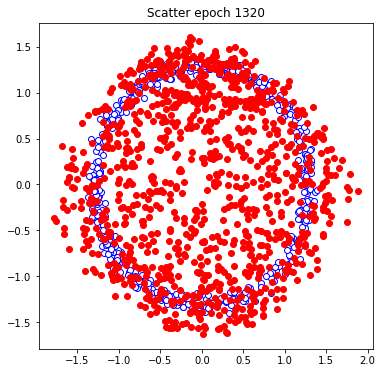

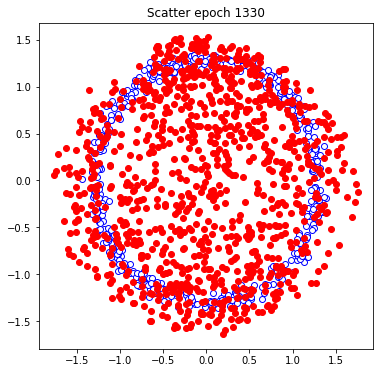

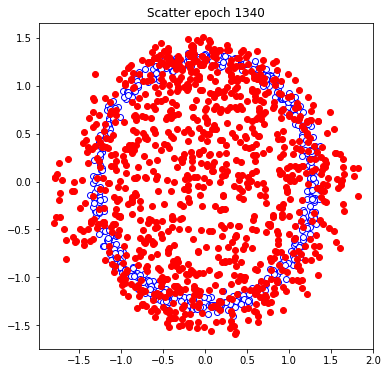

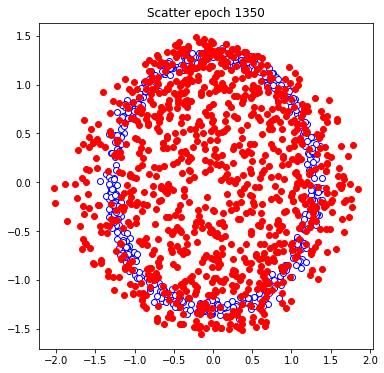

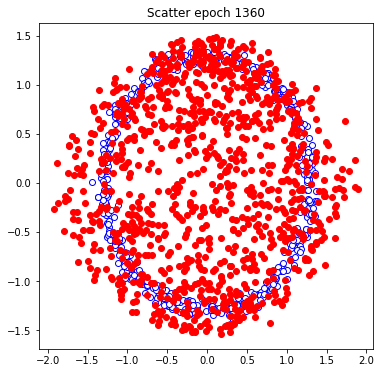

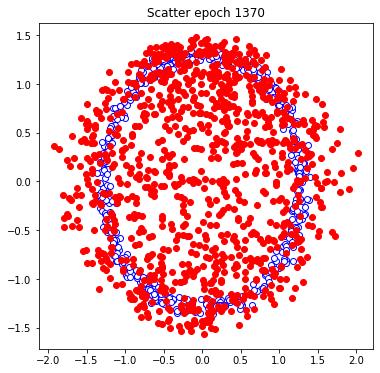

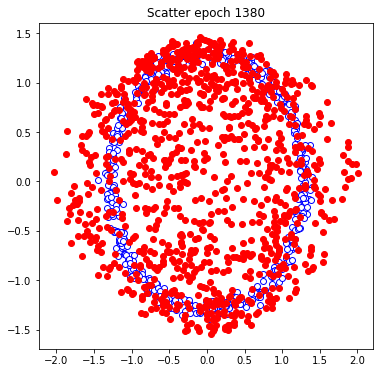

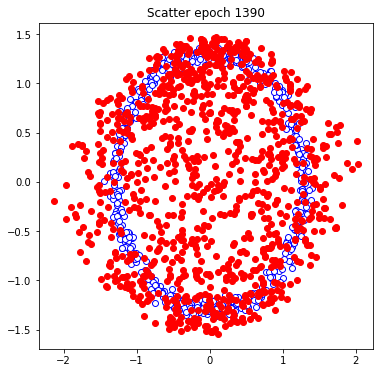

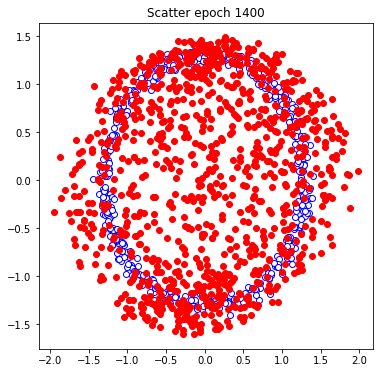

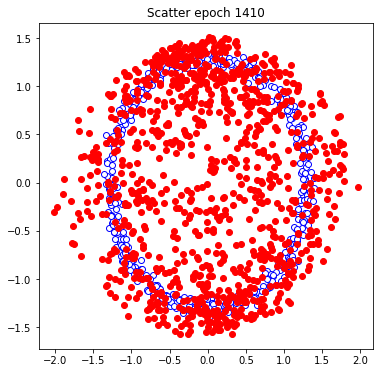

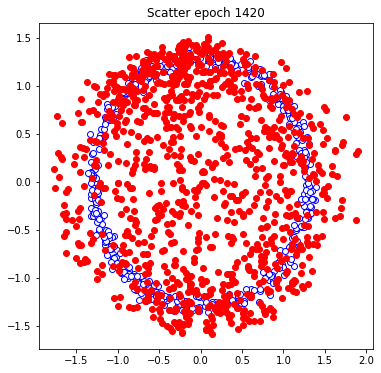

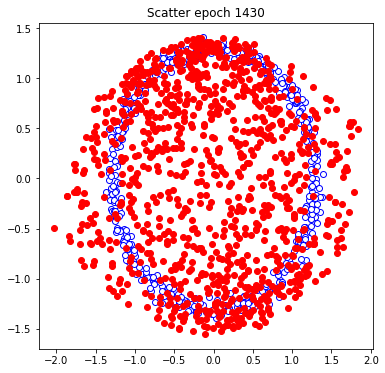

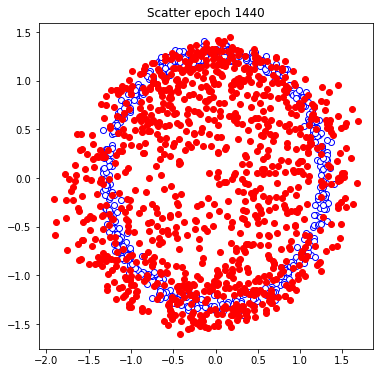

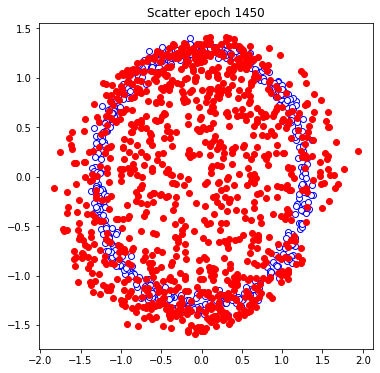

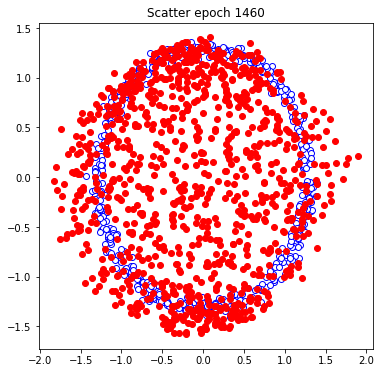

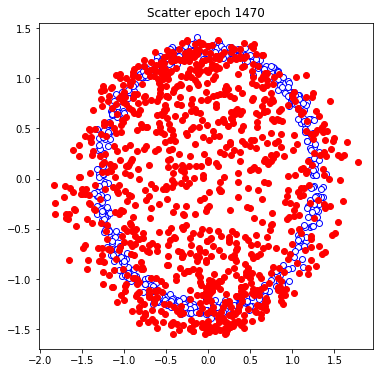

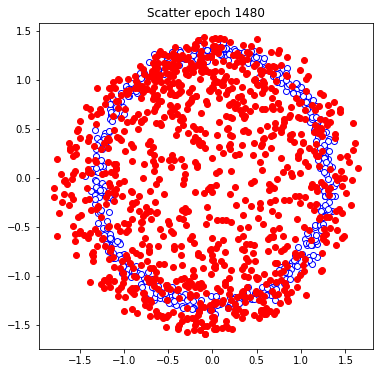

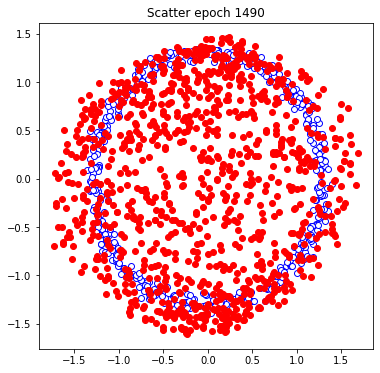

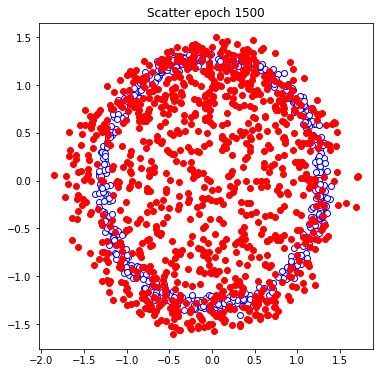

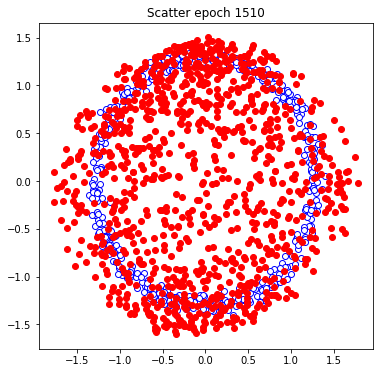

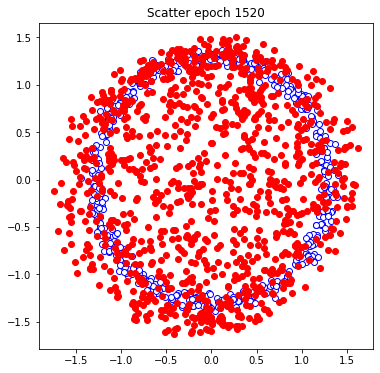

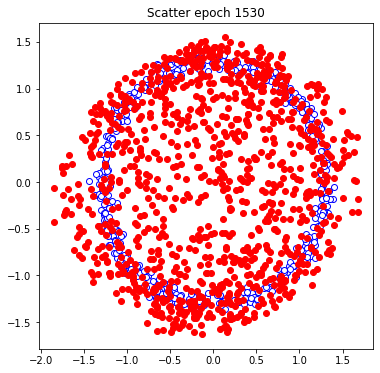

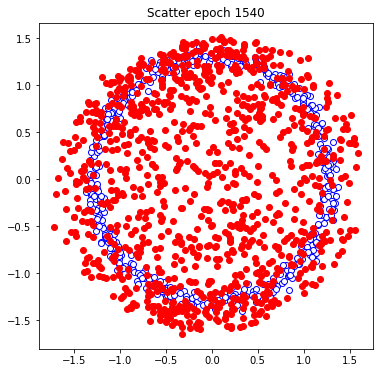

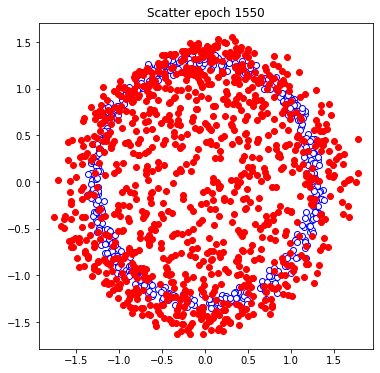

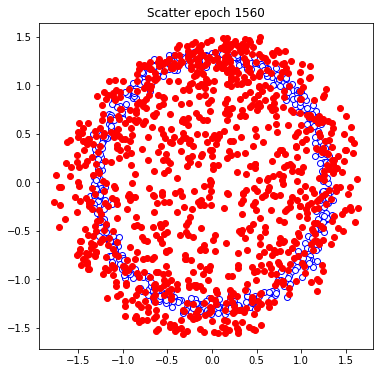

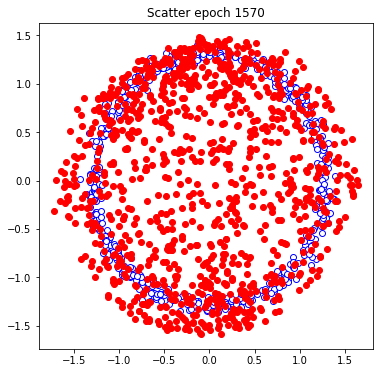

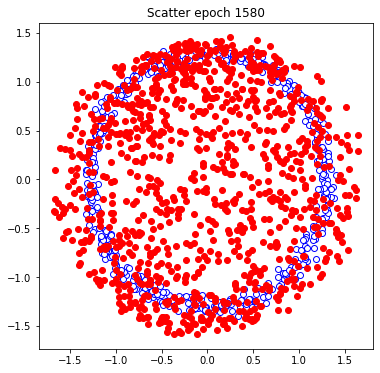

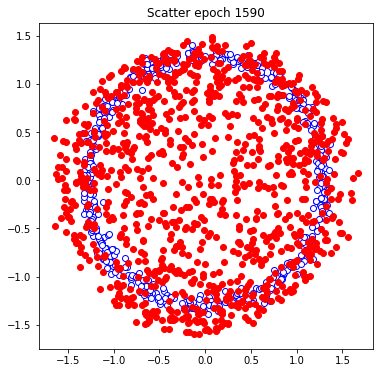

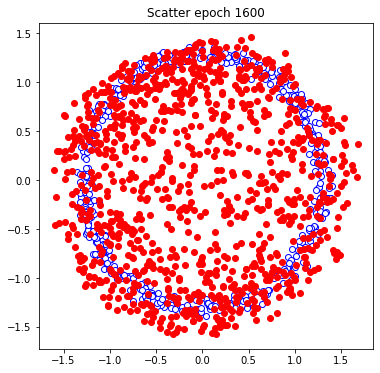

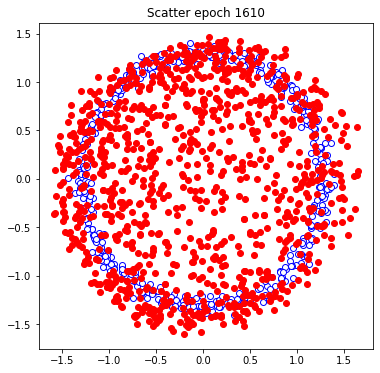

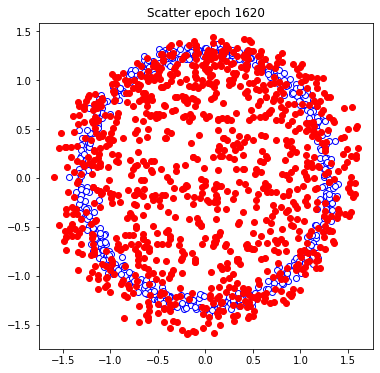

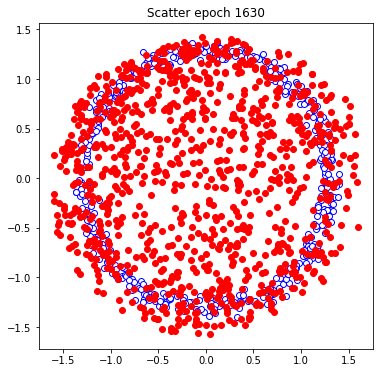

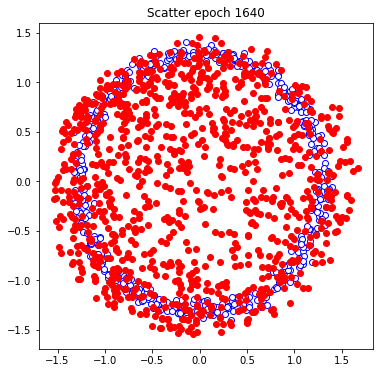

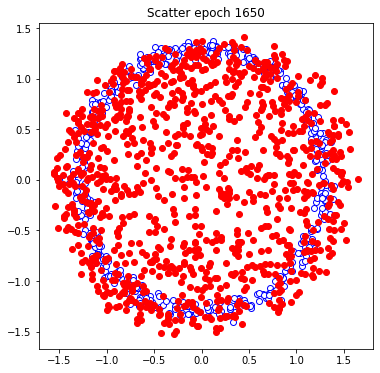

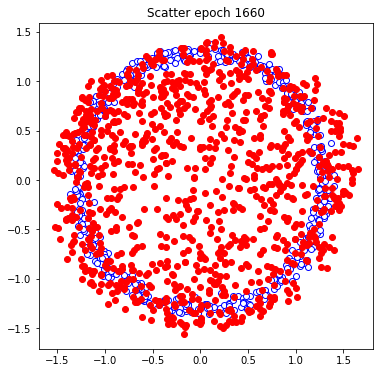

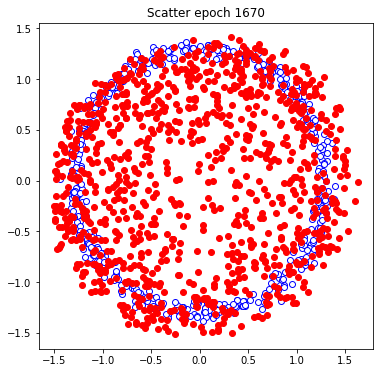

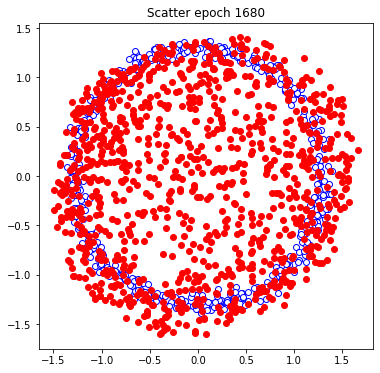

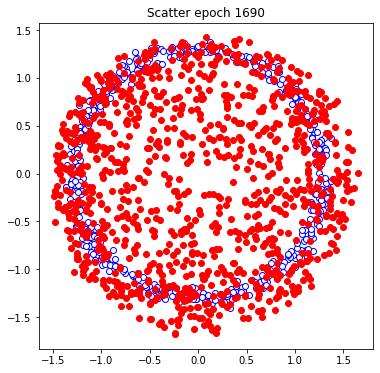

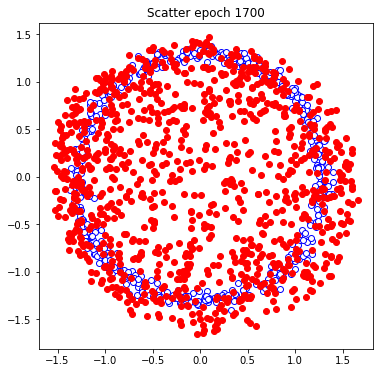

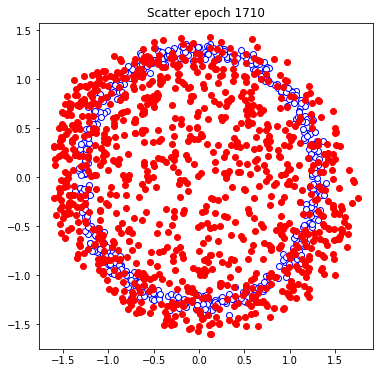

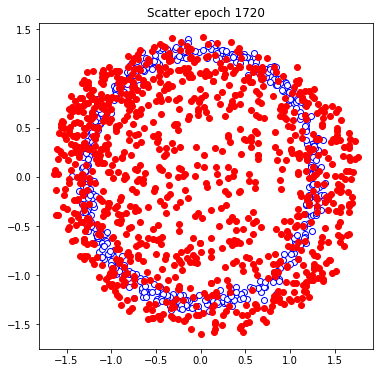

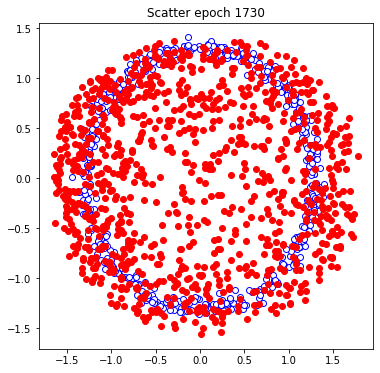

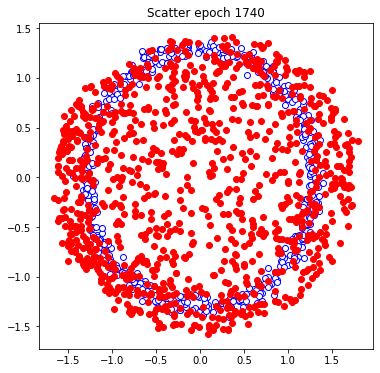

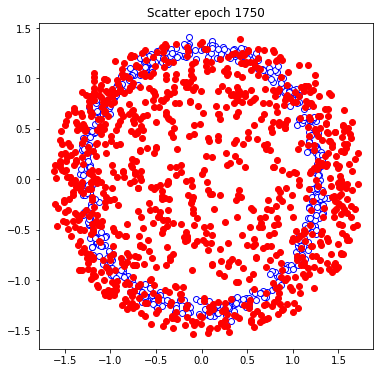

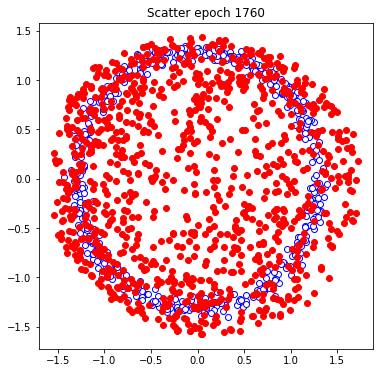

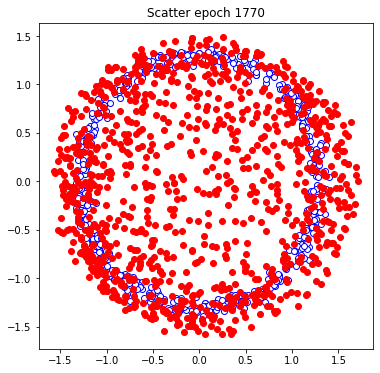

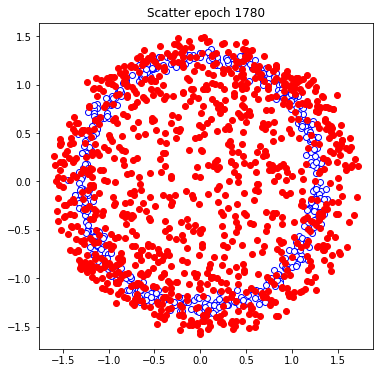

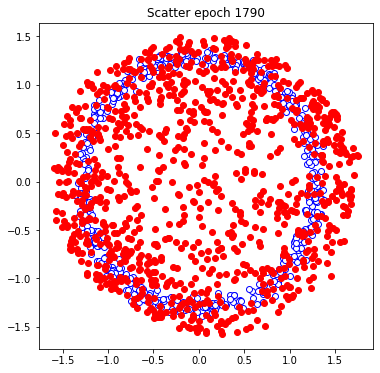

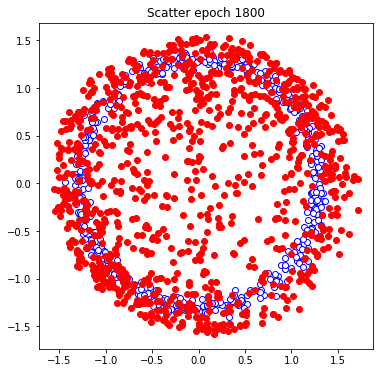

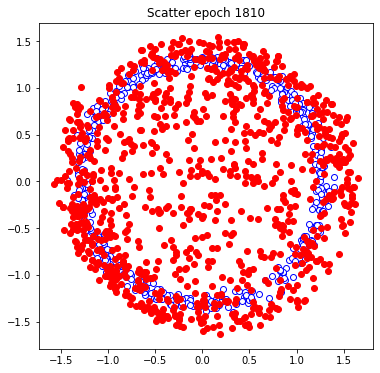

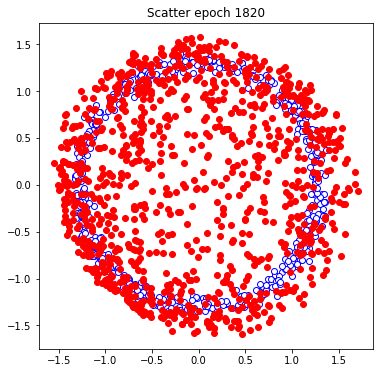

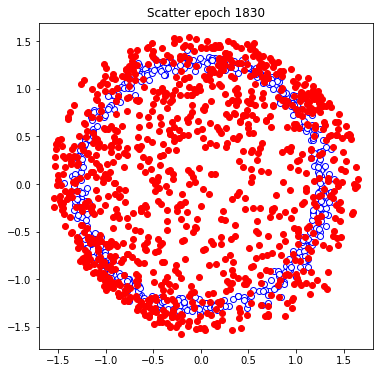

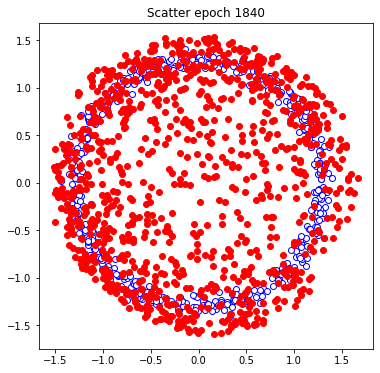

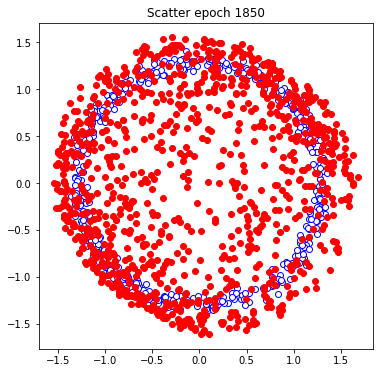

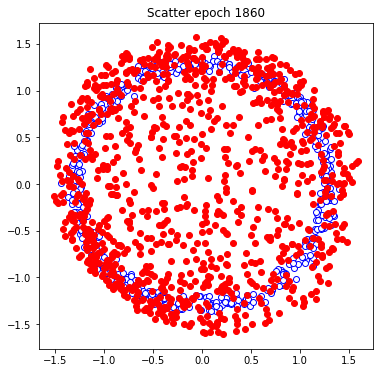

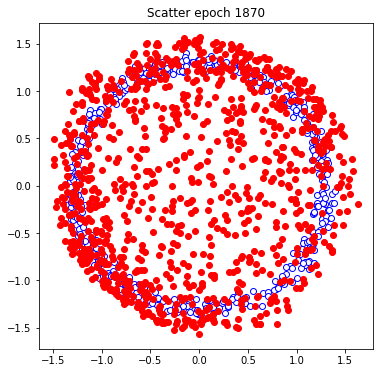

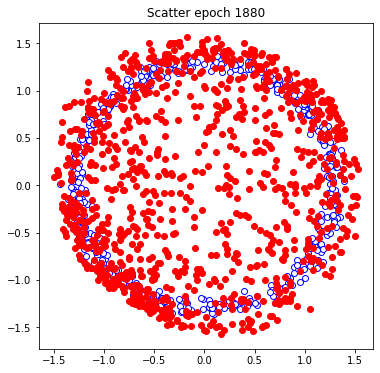

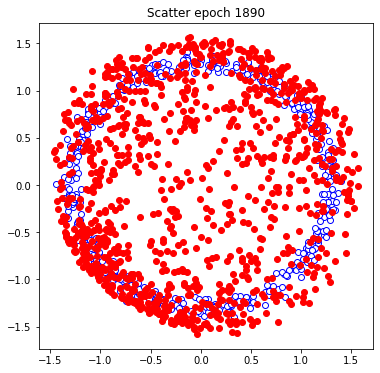

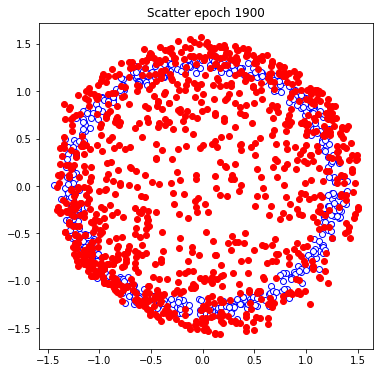

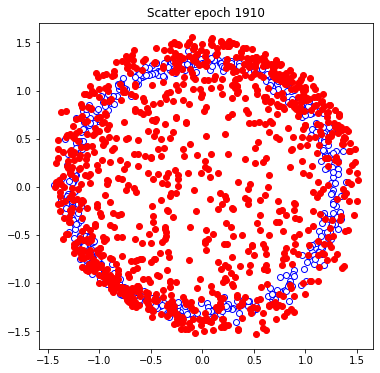

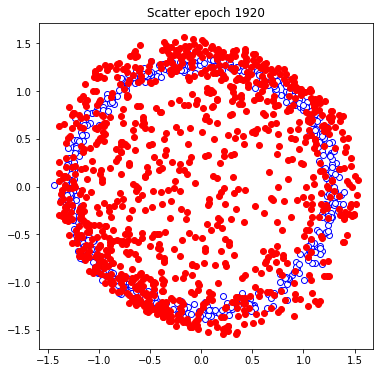

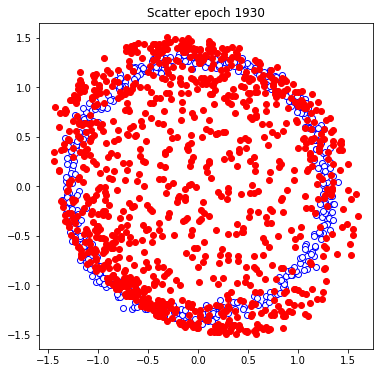

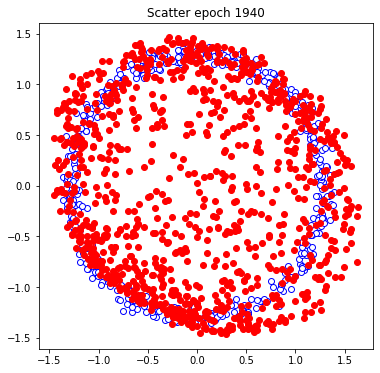

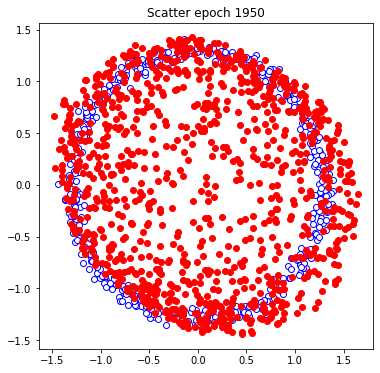

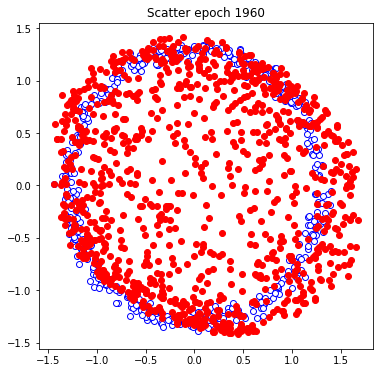

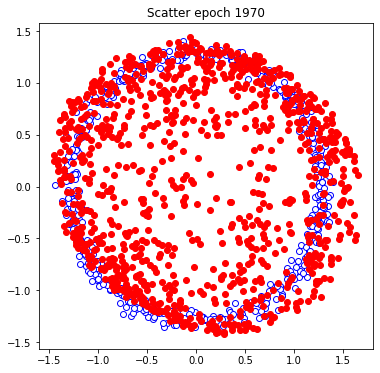

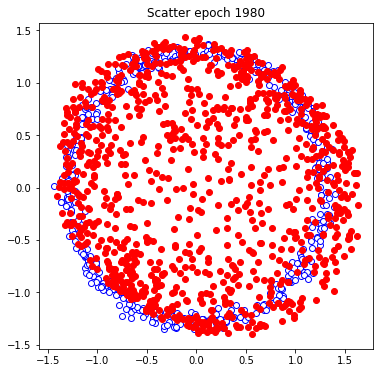

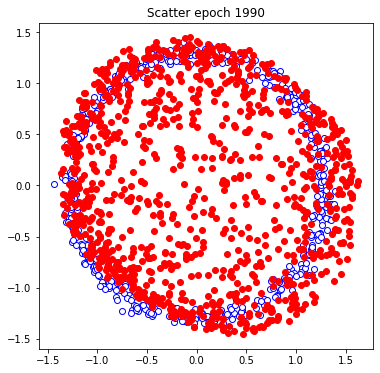

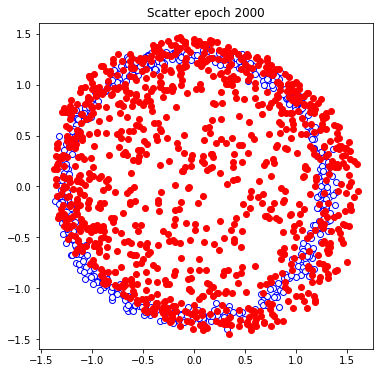

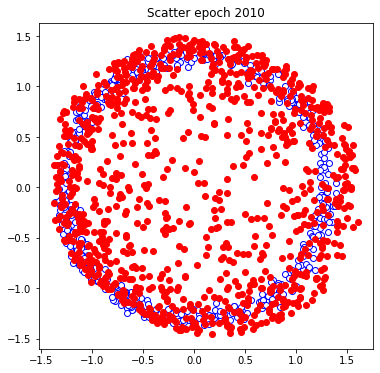

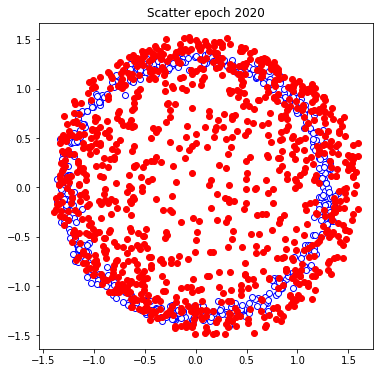

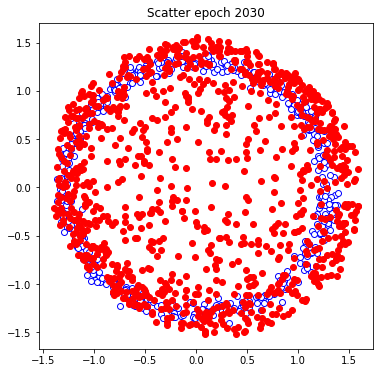

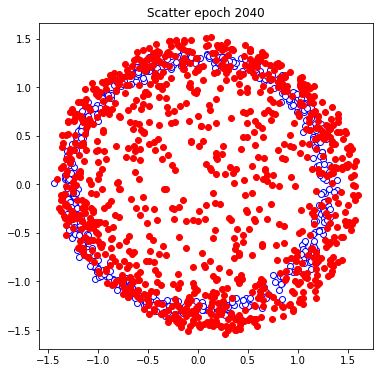

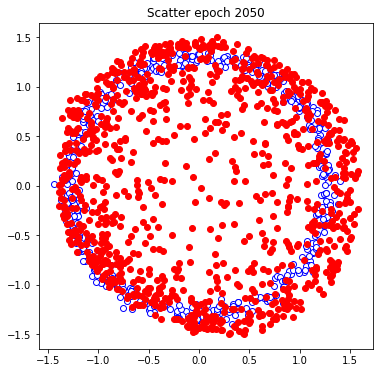

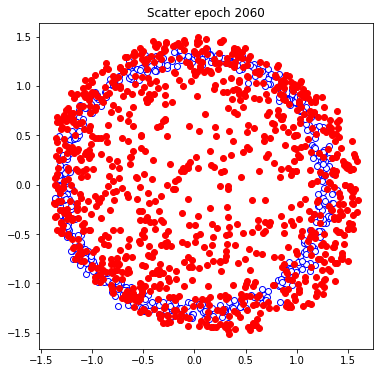

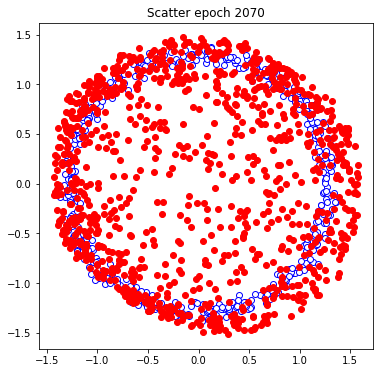

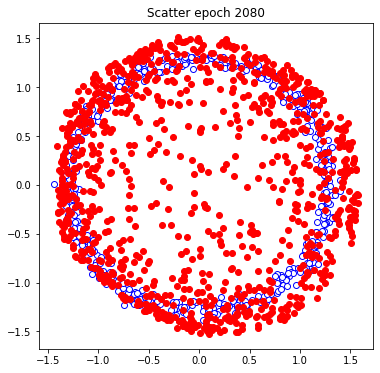

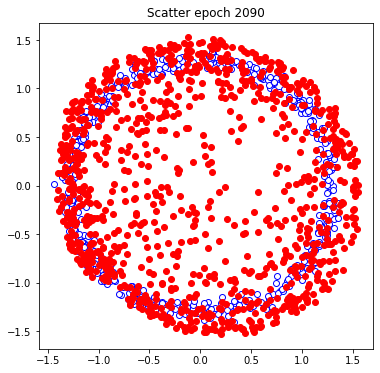

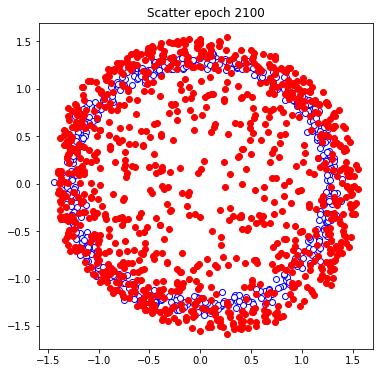

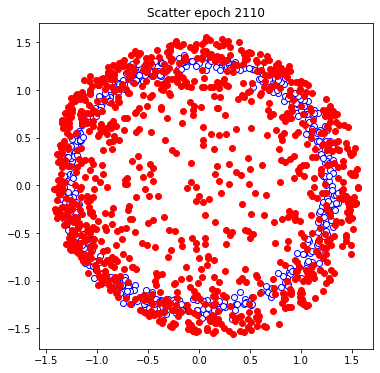

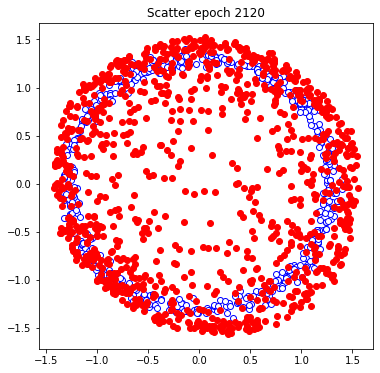

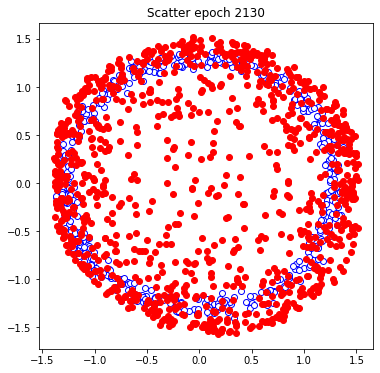

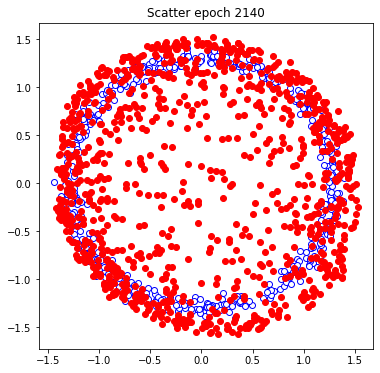

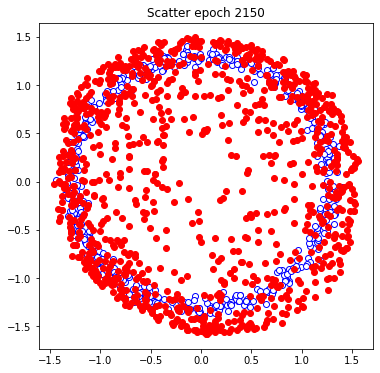

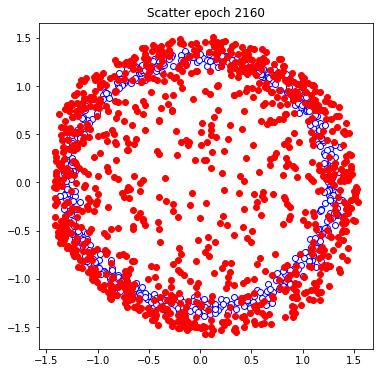

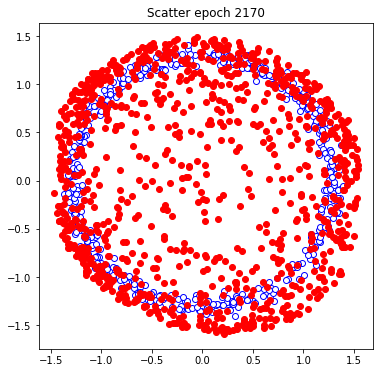

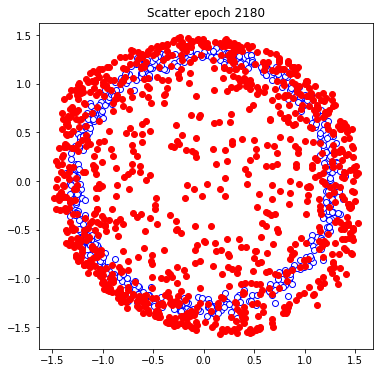

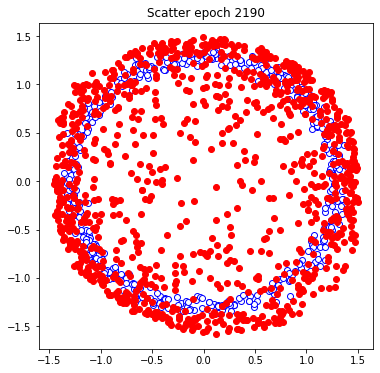

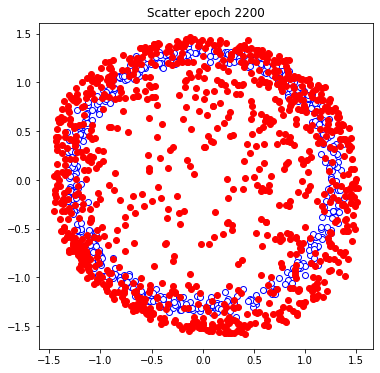

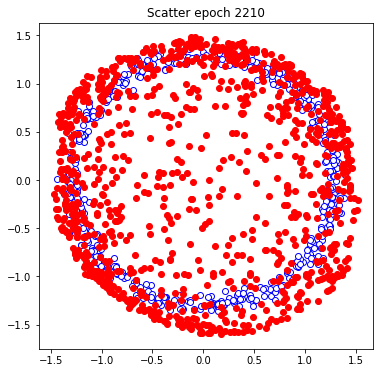

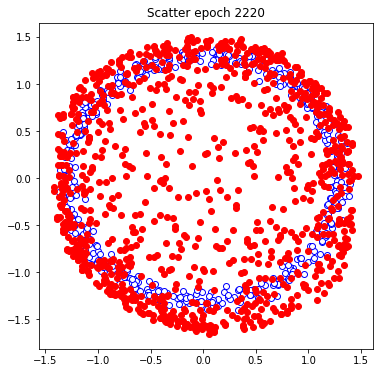

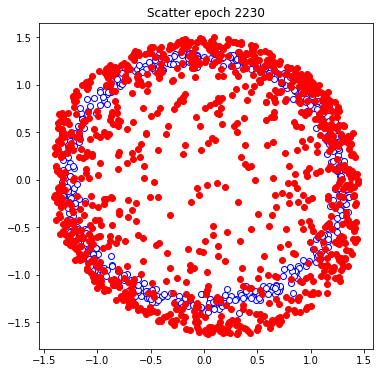

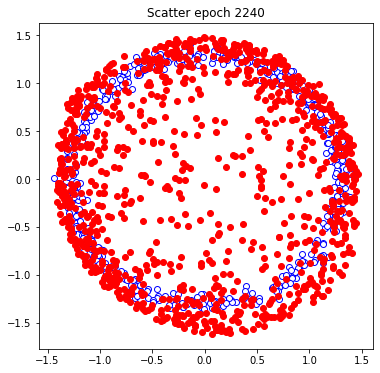

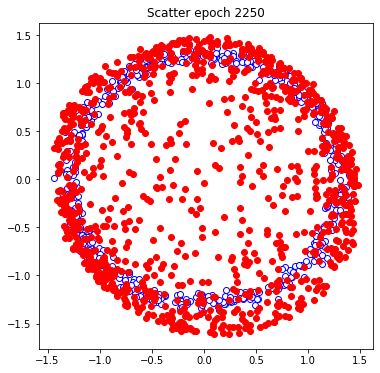

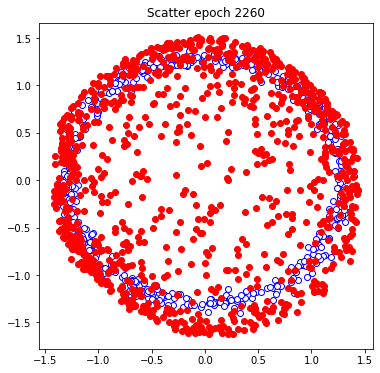

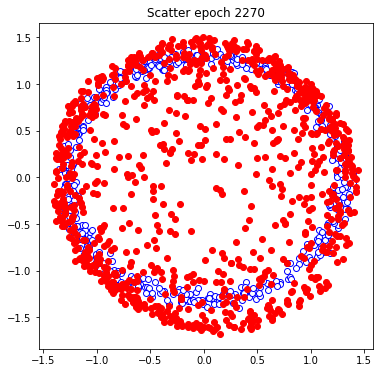

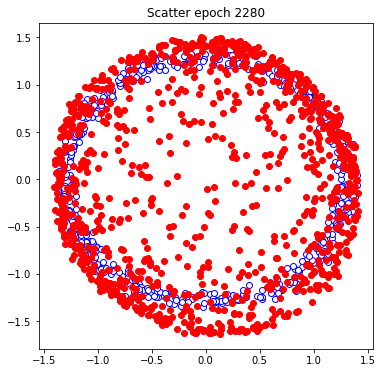

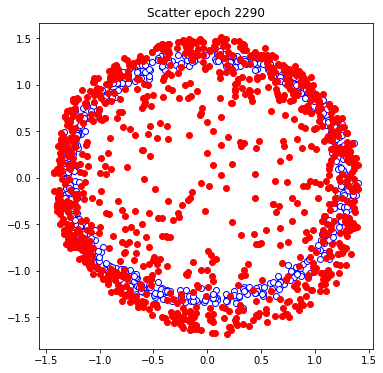

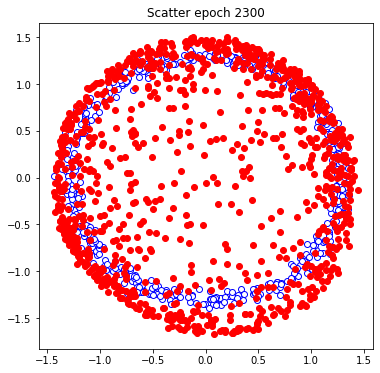

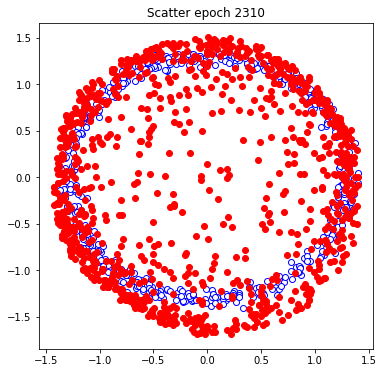

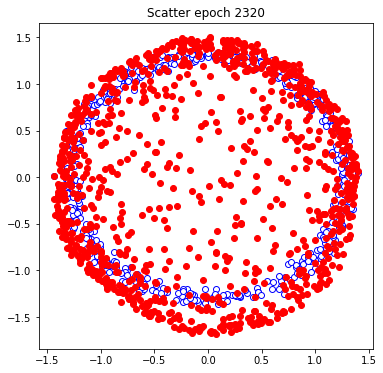

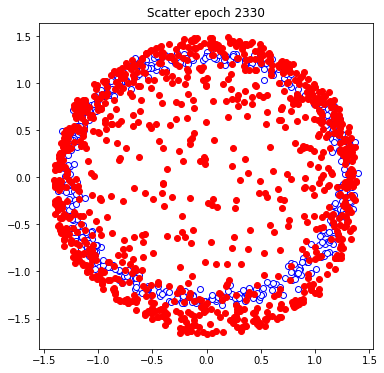

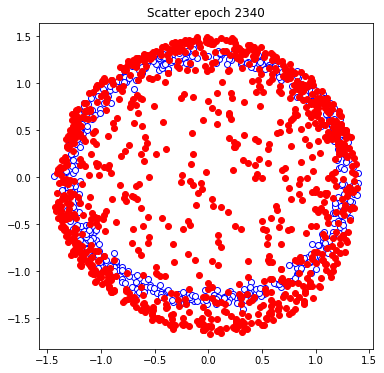

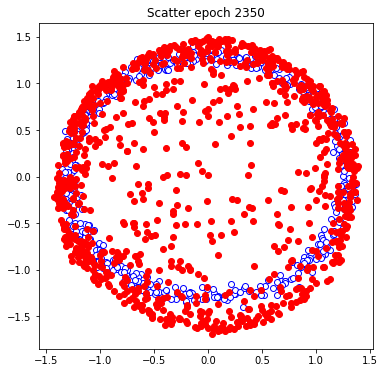

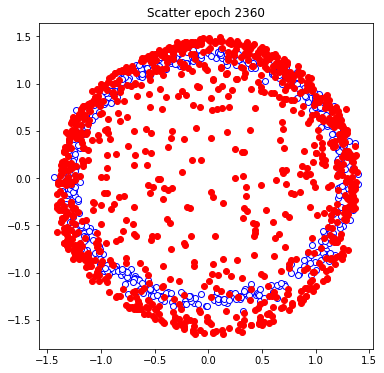

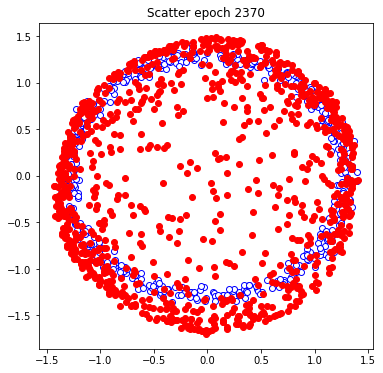

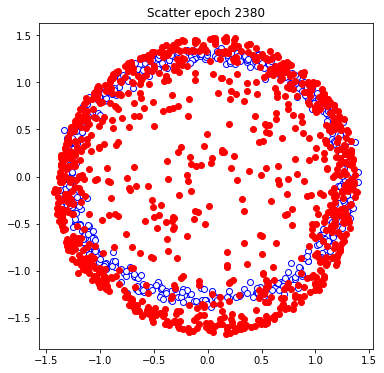

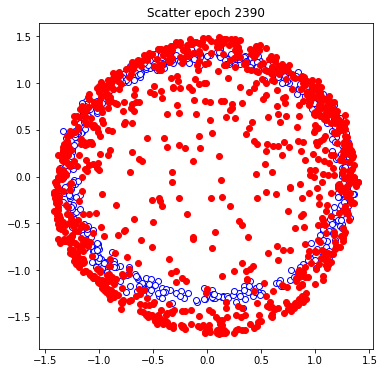

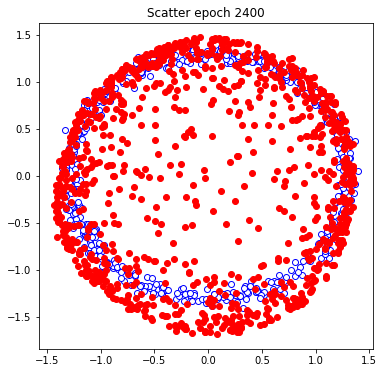

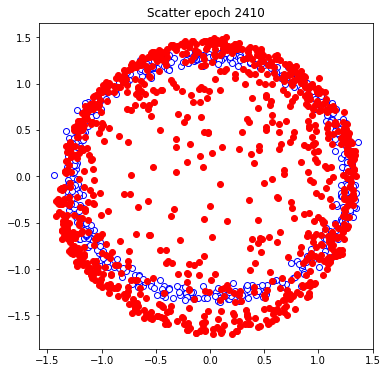

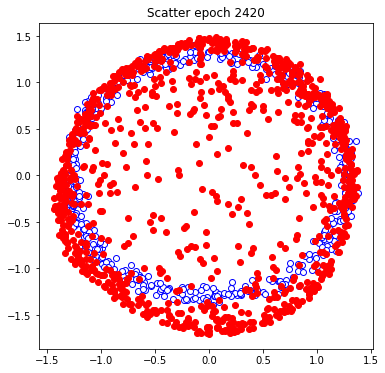

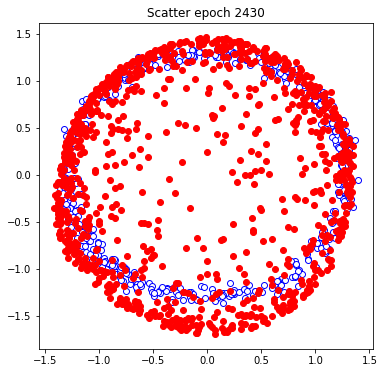

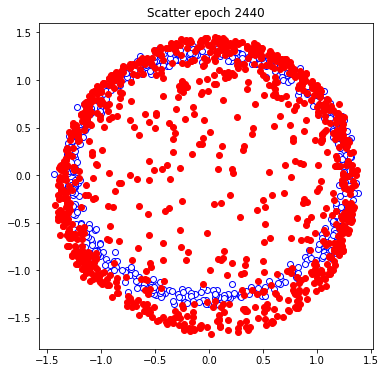

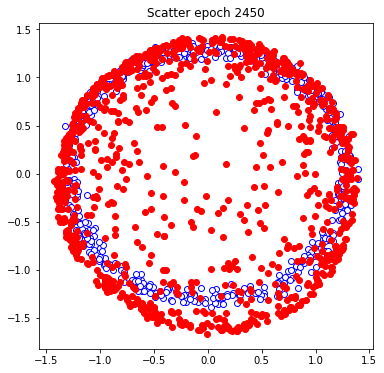

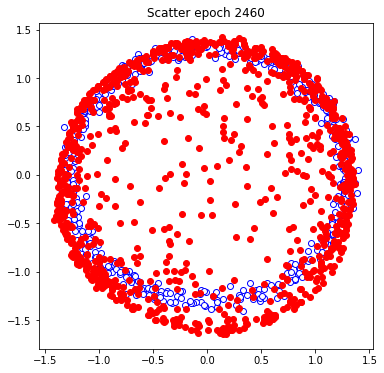

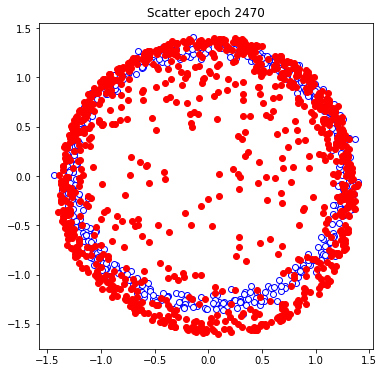

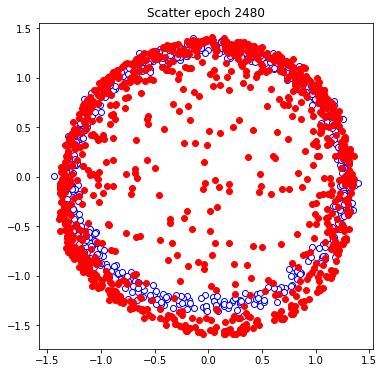

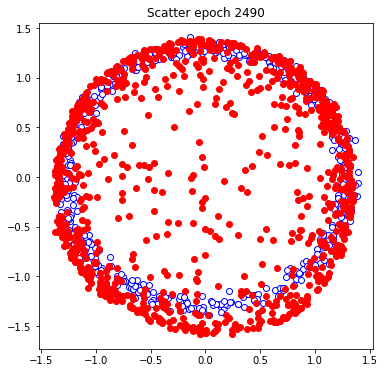

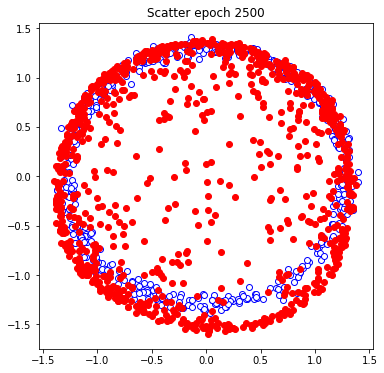

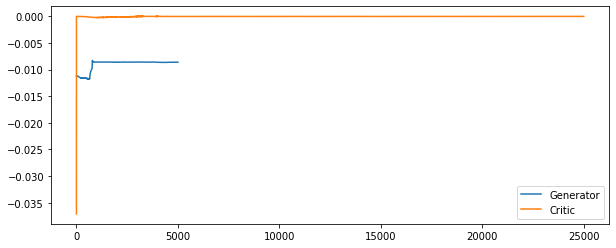

In [ ]:
# Start training

#gen.train()
#crt.train()

CRITIC_ITERATIONS =5
g_losses = []
c_losses = []
weight_clip =0.01

total_step = len(data_loader)
for epoch in range(num_epochs):
    for step, x in enumerate(data_loader):
        #print(x)
        real_data = x[0]
        #print(real_data)
        
       
        for _ in range(CRITIC_ITERATIONS):
            critic_real = C(real_data)
           
            noise = torch.randn(batch_size, latent_size)
            fake_data = G(noise)
            
            critic_fake = C(fake_data)
          
            #calculate critic loss
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
                
            
            #crt.zero_grad()
            c_optimizer.zero_grad()
            loss_critic.backward(retain_graph=True)
            c_optimizer.step()

            c_losses.append(loss_critic.item())
            
            # clip critic weights between -0.01, 0.01
            for p in C.parameters():
                p.data.clamp_(-weight_clip, weight_clip)


        
        
        # Train Generator:
        gen_fake = C(fake_data)
        # Here let the generator learn to move the loss function towards the side of the true sample
        loss_gen = -torch.mean(gen_fake)

        g_optimizer.zero_grad()
        #torch.autograd.set_detect_anomaly(True)
        loss_gen.backward()
        g_optimizer.step()
  
        g_losses.append(loss_gen.item())
        
       
  
    
    
    if (epoch+1)%10==0:
        # Generate some fake data points from the generator sample
        z = torch.randn(1000, latent_size)
        with torch.no_grad():
            fake_data = G(z)
        fake_x,fake_y = fake_data[:,0].numpy(),fake_data[:,1].numpy()
        real_x,real_y = real_data[:,0].numpy(),real_data[:,1].numpy()

        
        
        
        step = 0.02
        x = np.arange(-2,2,step)
        y = np.arange(-2,2,step)

        #Turn the original data into grid data form
        X,Y = np.meshgrid(x,y)
        n,m = X.shape
        #Write function, z is uppercase
        inputs = torch.stack([torch.FloatTensor(X),torch.FloatTensor(Y)])
        inputs = inputs.permute(1,2,0)
        inputs = inputs.reshape(-1,2)
        with torch.no_grad():
            Z = C(inputs)
        Z = Z.numpy().reshape(n,m)
        
       
        plt.figure(figsize=(6,6))

        plt.scatter(real_x,real_y,c = 'w', edgecolor='b')
        plt.scatter(fake_x,fake_y,c = 'r')
        plt.title('Scatter epoch %d'%(epoch+1))
        plt.show()
        
plt.figure(figsize=(10,4))
plt.plot(g_losses,label='Generator')
plt.plot(c_losses,label='Critic')
plt.legend()